In [263]:
import pandas as pd
import requests
from urllib import parse
import time as t
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from scipy.special import boxcox, inv_boxcox
from scipy import stats
from scipy.stats import skew
import requests
import json
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import math
import plotly.graph_objects as go
from warnings import simplefilter
import datetime


# National Electrcity historical Demand Data from National Grid website: https://www.neso.energy/data-portal/historic-demand-data

Historic electricity demand, interconnector, wind and solar outturn data for 2025. Please find a brief summary of some of the columns in the dataset:

ND = National Demand is the sum of metered generation, but excludes generation required to meet station load, hydro storage pumping and interconnector exports

FORECAST_ACTUAL_INDICATOR = Indication of whether data is out-turn (A) or forecast (F)

I014_ND = Equivalent to ND but calculated using settlement metered generation data from the I014 file where available

TSD = Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports

I014_TSD = Equivalent to TSD (above), but calculated using settlement metered generation data from the I014 file where available

In [8]:
tables = [#2019
    'SELECT * FROM  "dd9de980-d724-415a-b344-d8ae11321432" ORDER BY "_id"',
          #2020
    'SELECT * FROM  "33ba6857-2a55-479f-9308-e5c4c53d4381" ORDER BY "_id"',
    #2021
    'SELECT * FROM  "18c69c42-f20d-46f0-84e9-e279045befc6" ORDER BY "_id"',
    #2022
    'SELECT * FROM  "bb44a1b5-75b1-4db2-8491-257f23385006" ORDER BY "_id"',
    #2023
    'SELECT * FROM  "bf5ab335-9b40-4ea4-b93a-ab4af7bce003" ORDER BY "_id"',
    #2024
    'SELECT * FROM  "f6d02c0f-957b-48cb-82ee-09003f2ba759" ORDER BY "_id"',
    #2025
    'SELECT * FROM  "b2bde559-3455-4021-b179-dfe60c0337b0" ORDER BY "_id"'
         ]

In [286]:
for i in tables:
    print (i)

SELECT * FROM  "dd9de980-d724-415a-b344-d8ae11321432" ORDER BY "_id"
SELECT * FROM  "33ba6857-2a55-479f-9308-e5c4c53d4381" ORDER BY "_id"
SELECT * FROM  "18c69c42-f20d-46f0-84e9-e279045befc6" ORDER BY "_id"
SELECT * FROM  "bb44a1b5-75b1-4db2-8491-257f23385006" ORDER BY "_id"
SELECT * FROM  "bf5ab335-9b40-4ea4-b93a-ab4af7bce003" ORDER BY "_id"
SELECT * FROM  "f6d02c0f-957b-48cb-82ee-09003f2ba759" ORDER BY "_id"
SELECT * FROM  "b2bde559-3455-4021-b179-dfe60c0337b0" ORDER BY "_id"


In [265]:
##Data Load and transformation to Pandas dataframe
df = pd.DataFrame()
for i in tables:
    #print (i)
    t.sleep(3)
    sql_query = i
    params = {
    'sql'
    : sql_query}
    
    try:
        resposne = requests.get(
    'https://api.neso.energy/api/3/action/datastore_search_sql'
    , params = parse.urlencode(params))
        data = resposne.json()[
    "result"
    ]
        df = pd.concat([df, pd.DataFrame(data['records'])], axis = 0) 
    except requests.exceptions.RequestException as e:
        print(e.response.text)

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107232 entries, 0 to 2015
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   EMBEDDED_SOLAR_GENERATION  107232 non-null  int64  
 1   NON_BM_STOR                107232 non-null  int64  
 2   EMBEDDED_SOLAR_CAPACITY    107232 non-null  object 
 3   IFA2_FLOW                  107232 non-null  int64  
 4   IFA_FLOW                   107232 non-null  int64  
 5   ELECLINK_FLOW              107232 non-null  int64  
 6   _full_text                 107232 non-null  object 
 7   TSD                        107232 non-null  int64  
 8   BRITNED_FLOW               107232 non-null  int64  
 9   ND                         107232 non-null  int64  
 10  MOYLE_FLOW                 107232 non-null  int64  
 11  SETTLEMENT_PERIOD          107232 non-null  int64  
 12  SETTLEMENT_DATE            107232 non-null  object 
 13  ENGLAND_WALES_DEMAND       107232 no

In [283]:
df['EMBEDDED_SOLAR_CAPACITY'] = df['EMBEDDED_SOLAR_CAPACITY'].astype(float)
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])
#### adding new columns with Month and Year
df['year_month'] =  df.SETTLEMENT_DATE.astype(str).str.slice(stop = 7)
#### adding new columns with YMD
df['year'] =  df.SETTLEMENT_DATE.astype(str).str.slice(stop = 4)
#### adding new columns with YMD
df['month'] =  df.SETTLEMENT_DATE.astype(str).str.slice(start= 5,stop = 7)
df['day'] =  df.SETTLEMENT_DATE.astype(str).str.slice(start= 8,stop = 10)
df['dayofyear'] = df['SETTLEMENT_DATE'].dt.dayofyear
#### converting month to int (encoding)
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
df['day'] = df['day'].astype(int)
df['iso_week'] = df['SETTLEMENT_DATE'].dt.isocalendar().week
df['iso_day'] = df['SETTLEMENT_DATE'].dt.isocalendar().day
df = df.set_index(['SETTLEMENT_DATE','SETTLEMENT_PERIOD'])

In [774]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107664 entries, 0 to 2447
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   EMBEDDED_SOLAR_GENERATION  107664 non-null  int64         
 1   NON_BM_STOR                107664 non-null  int64         
 2   EMBEDDED_SOLAR_CAPACITY    107664 non-null  float64       
 3   IFA2_FLOW                  107664 non-null  int64         
 4   IFA_FLOW                   107664 non-null  int64         
 5   ELECLINK_FLOW              107664 non-null  int64         
 6   _full_text                 107664 non-null  object        
 7   TSD                        107664 non-null  int64         
 8   BRITNED_FLOW               107664 non-null  int64         
 9   ND                         107664 non-null  int64         
 10  MOYLE_FLOW                 107664 non-null  int64         
 11  SETTLEMENT_PERIOD          107664 non-null  int64         


##Total daily analysis for ND

In [775]:
#Basic Statistics
df.describe().ND

count    107664.000000
mean      27434.371415
min       13367.000000
25%       22453.000000
50%       26607.500000
75%       31611.250000
max       47081.000000
std        6403.802494
Name: ND, dtype: float64

<Axes: title={'center': 'National Demand'}, xlabel='SETTLEMENT_DATE', ylabel='ND'>

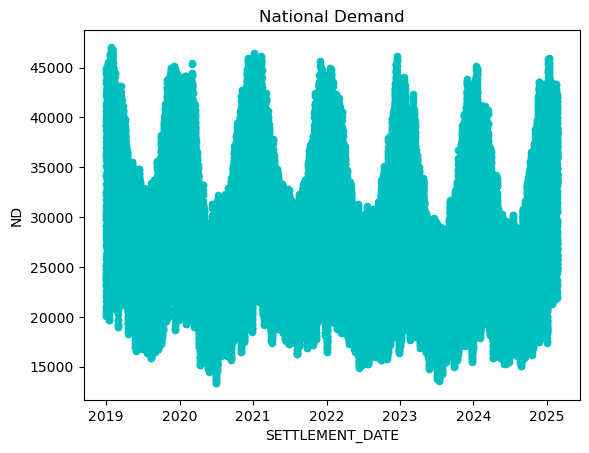

In [776]:
df.reset_index().plot.scatter(x= 'SETTLEMENT_DATE' ,y= 'ND' ,color ='c',title='National Demand')

In [1014]:
df = df.set_index(['SETTLEMENT_DATE','SETTLEMENT_PERIOD'])

In [15]:
# plot parameters definition
simplefilter("ignore")
# Set Matplotlib defaults
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

The higher coefficient next to x^2 the more steepy trend line is
It would be useful to check the steepiness of the trend during different periods, as I am expecting trend to be less steepy overnight, due to less infulance of embeded generation

Mix trends of squeard and linear together as we don't assume that there will be only upwards trend it will change direction at some point 

Trend for all periods

trend: -0.10658259130896673
trend_squared: 7.546787123616619e-07
Intercept: 30262.529634216375


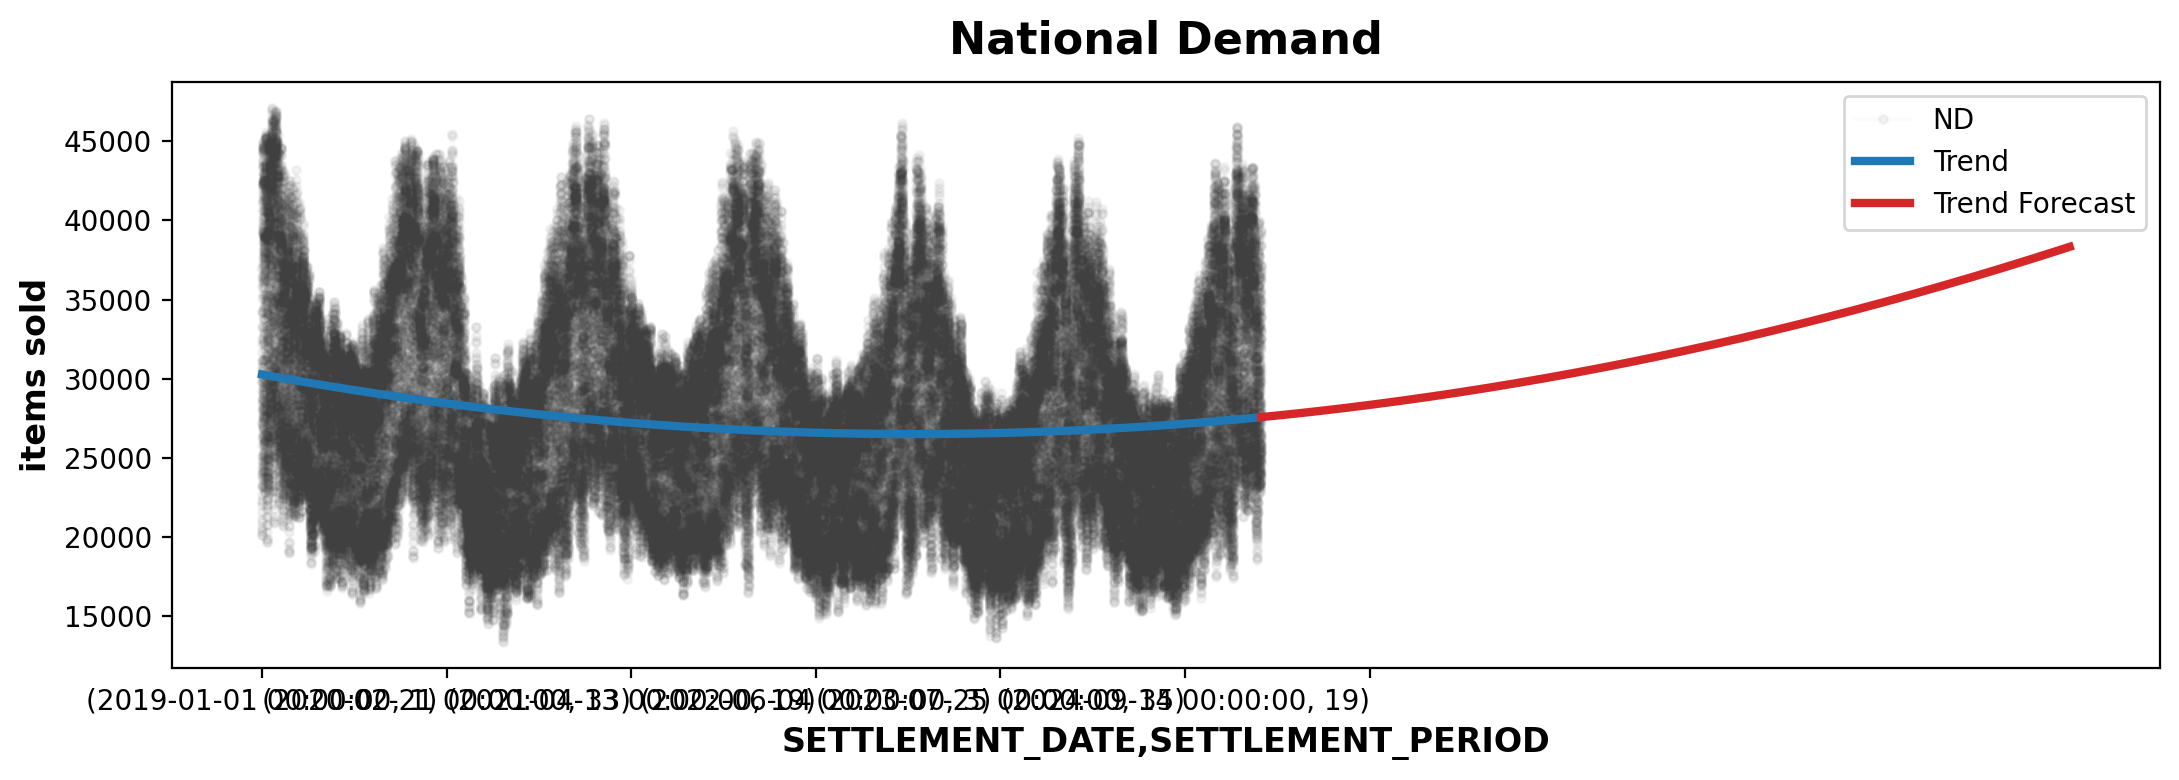

In [1217]:
y = df.ND.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index= df.index, order=2)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=365*5*48)

#trend
model = LinearRegression()
model.fit(X, y)

y_predSq= pd.Series(model.predict(X), index=X.index)
y_foreSq = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.05, title="National Demand", ylabel="items sold")
ax = y_predSq.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_foreSq.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();
# List all coefficient variables
coefficients = model.coef_
feature_names = X.columns

# Display coefficients with corresponding feature names
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')
print(f'Intercept:', model.intercept_)

trend: -0.024895412804227964
Intercept: 28788.86570493138


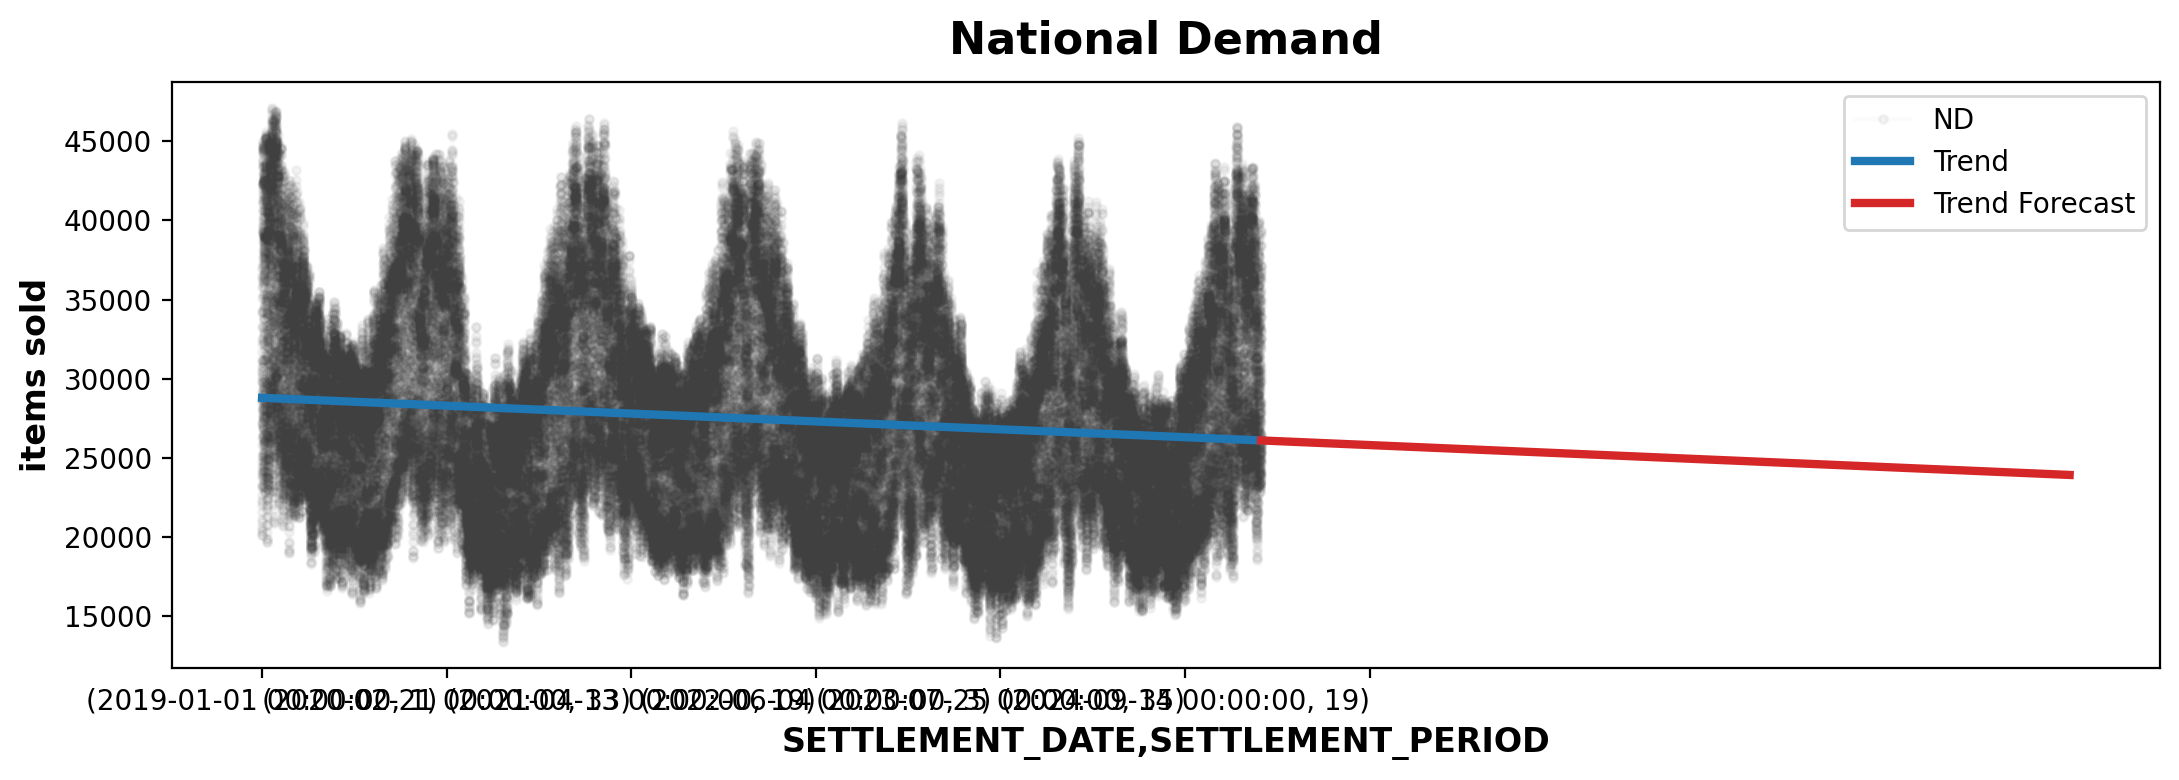

In [1219]:
y = df.ND.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index= df.index, order=1)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=365*5*48)

#trend
model = LinearRegression()
model.fit(X, y)

y_predLin = pd.Series(model.predict(X), index=X.index)
y_foreLin = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.05, title="National Demand", ylabel="items sold")
ax = y_predLin.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_foreLin.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();
# List all coefficient variables
coefficients = model.coef_
feature_names = X.columns

# Display coefficients with corresponding feature names
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')
print(f'Intercept:', model.intercept_)

Assumption that for the first 2 years teh trend will be Squered, asfter that it will be Linear

In [1221]:
#Assuming that there will be the Quadratic trend in the next 2 years and later linear trend
y_fore = pd.concat([y_foreSq[: 365 * 48 *2 ], y_foreLin[ 365 * 48 *2 :]], axis = 0)
#difference between two trends
TrendDifference = y_foreSq[143280] -y_foreLin[143280]
print('Trend Difference in 2 years' ,TrendDifference)
#we have to scale up Liner trand to match Squared trend in 2 years time
y_fore[ 365 * 48 *2 :] = y_fore[ 365 * 48 *2 :] + TrendDifference

Trend Difference in 2 years 5262.44382030662


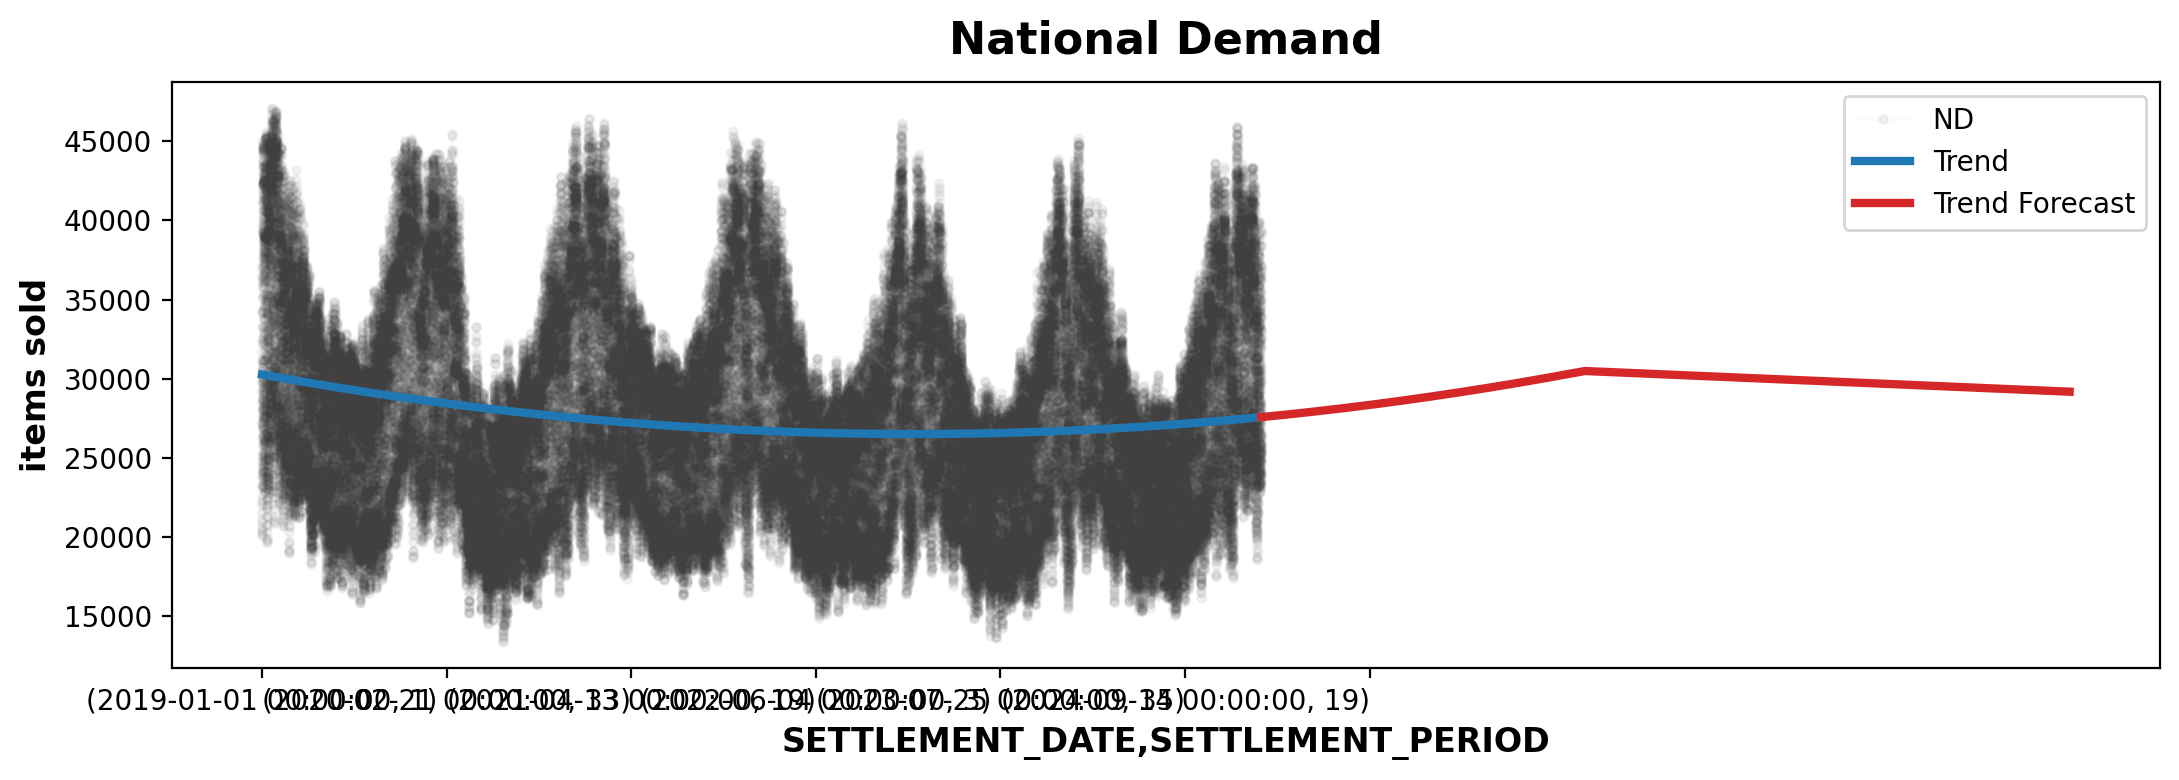

In [1223]:
ax = y.plot(**plot_params, alpha=0.05, title="National Demand", ylabel="items sold")
ax = y_predSq.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

Ternd for period during the night

trend: -4.067637083979069
trend_squared: 0.0015416810464240823
Intercept: 24491.325171228924


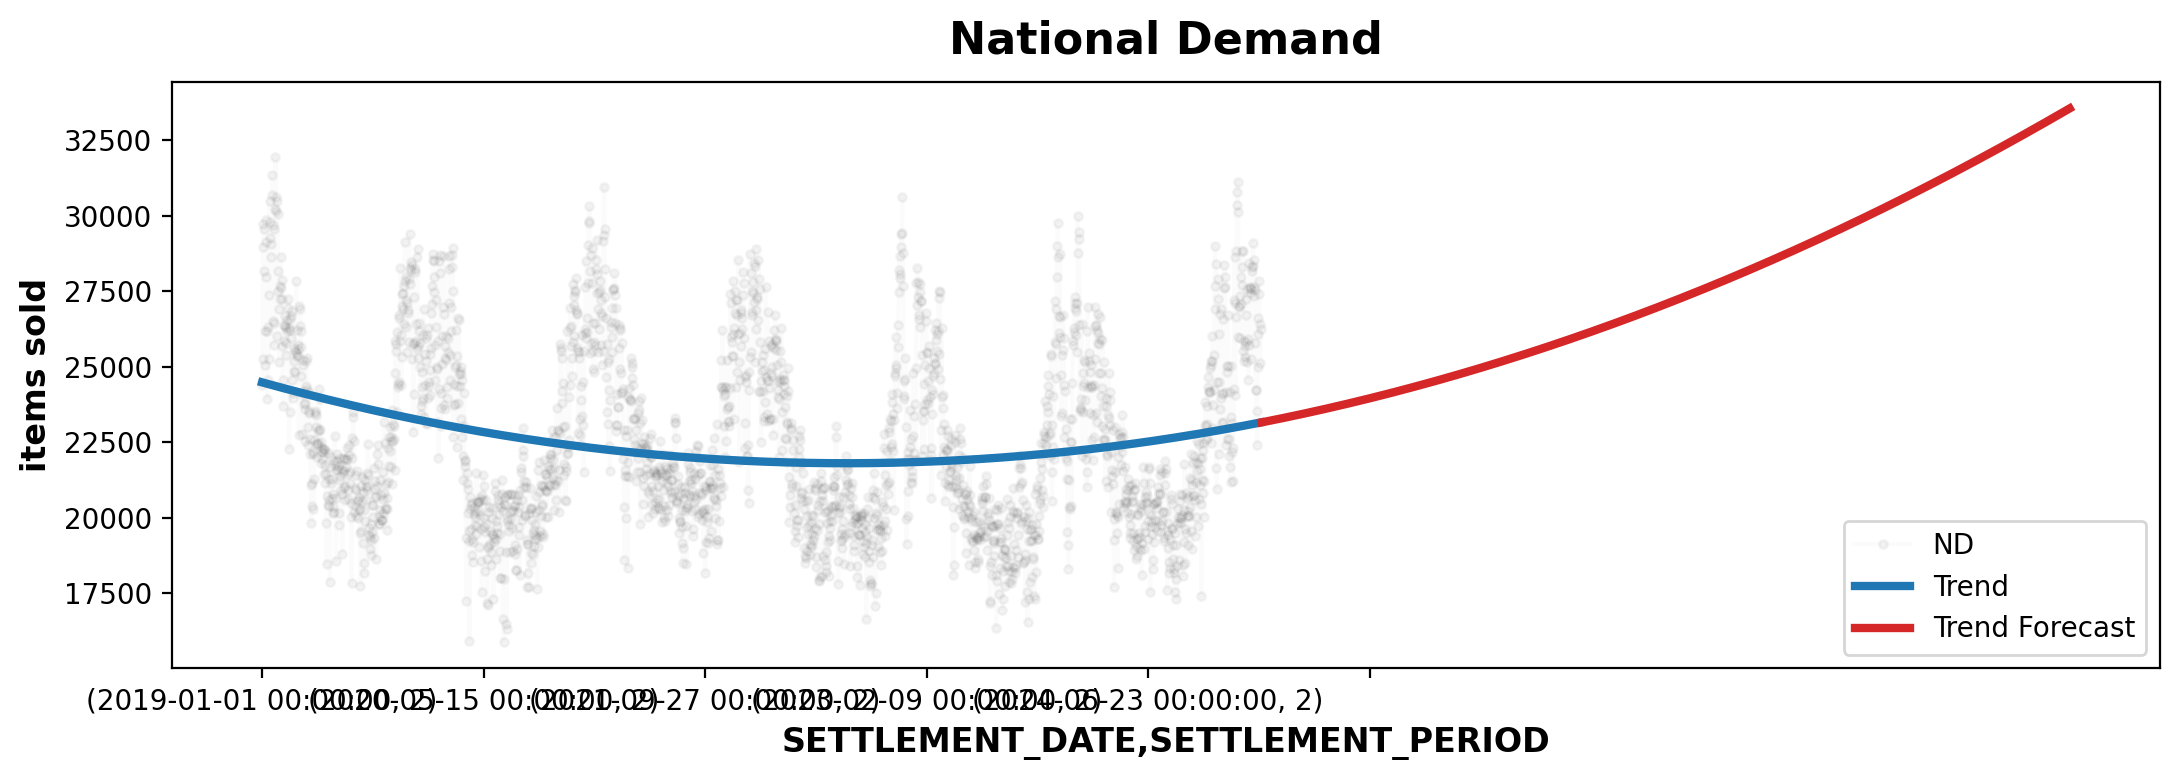

In [1089]:
ND_2 = df.loc[df.index.get_level_values('SETTLEMENT_PERIOD') == 2,]
y = ND_2.ND.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index= ND_2.index, order=2)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=365*5)

#Creating trend
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
#Chart
ax = y.plot(**plot_params, alpha=0.05, title="National Demand", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();
# List all coefficient variables
coefficients = model.coef_
feature_names = X.columns

# Display coefficients with corresponding feature names
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')
print(f'Intercept:', model.intercept_)

Trend for the middle of the day

trend: -5.758473934561599
trend_squared: 0.0019201285922894795
Intercept: 32721.82677393894


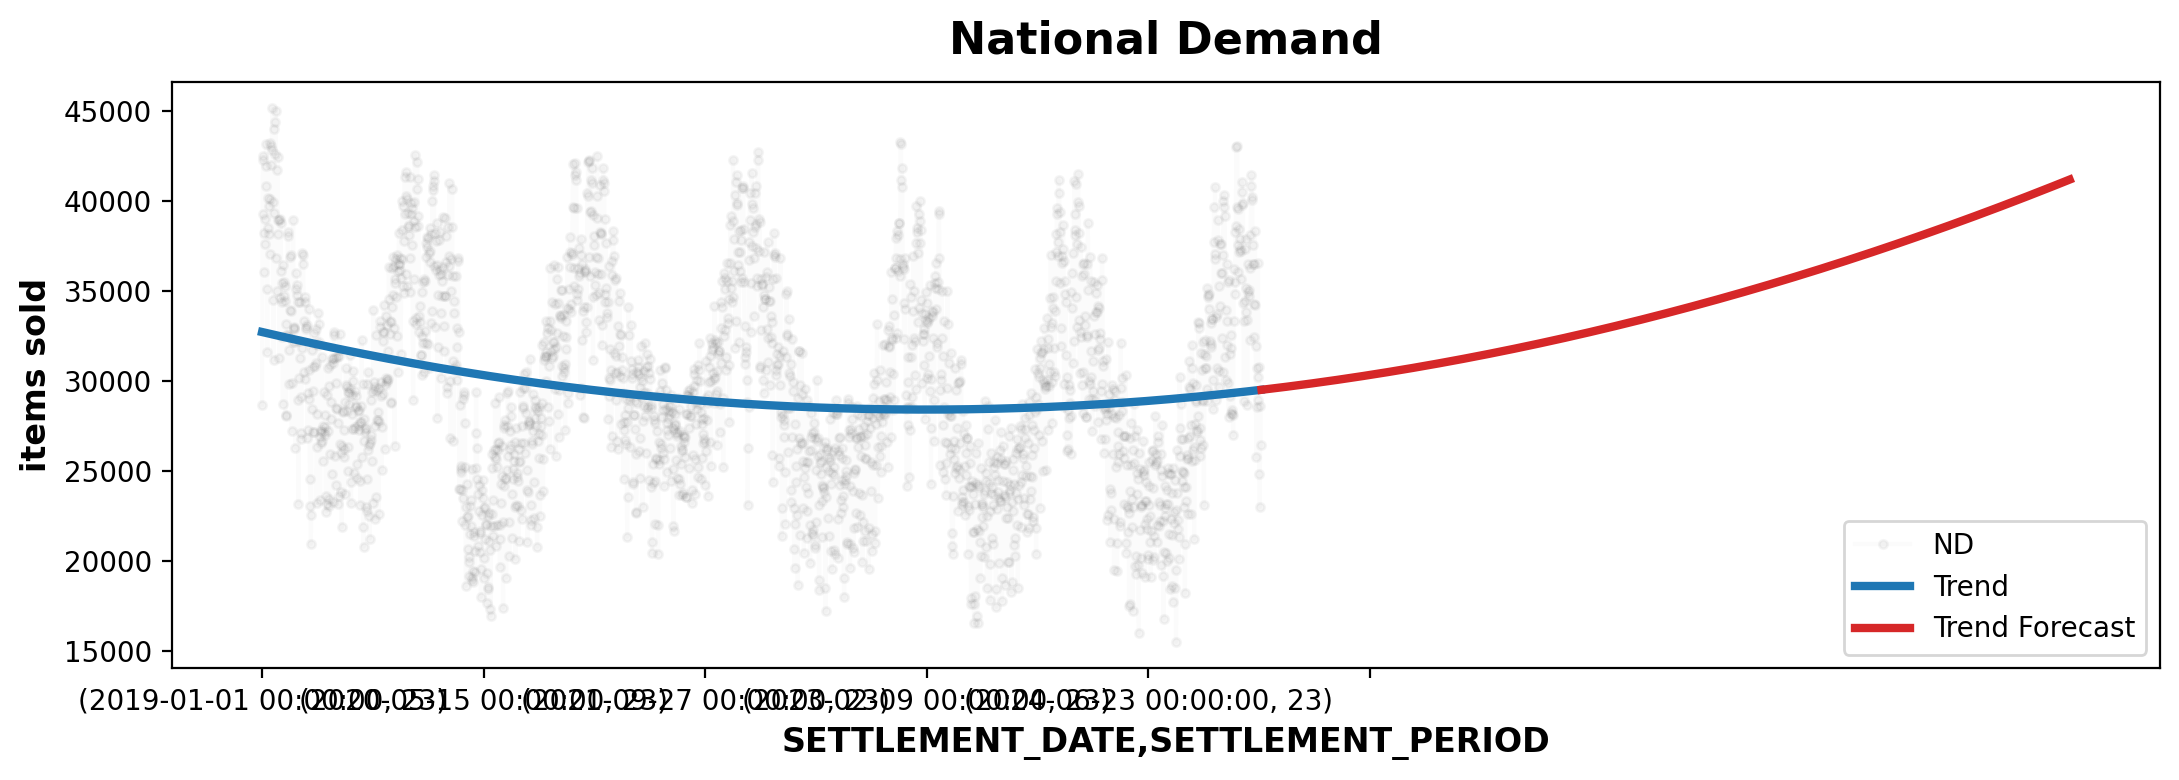

In [1097]:
ND_23 = df.loc[df.index.get_level_values('SETTLEMENT_PERIOD') == 23,]
y = ND_23.ND.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index= ND_23.index, order=2)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=365*5)

#Creating trend
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#Chart
ax = y.plot(**plot_params, alpha=0.05, title="National Demand", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();
# List all coefficient variables
coefficients = model.coef_
feature_names = X.columns

# Display coefficients with corresponding feature names
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')
print(f'Intercept:', model.intercept_)

trend: -5.758473934561599
trend_squared: 0.0019201285922894795
Intercept: 32721.82677393894


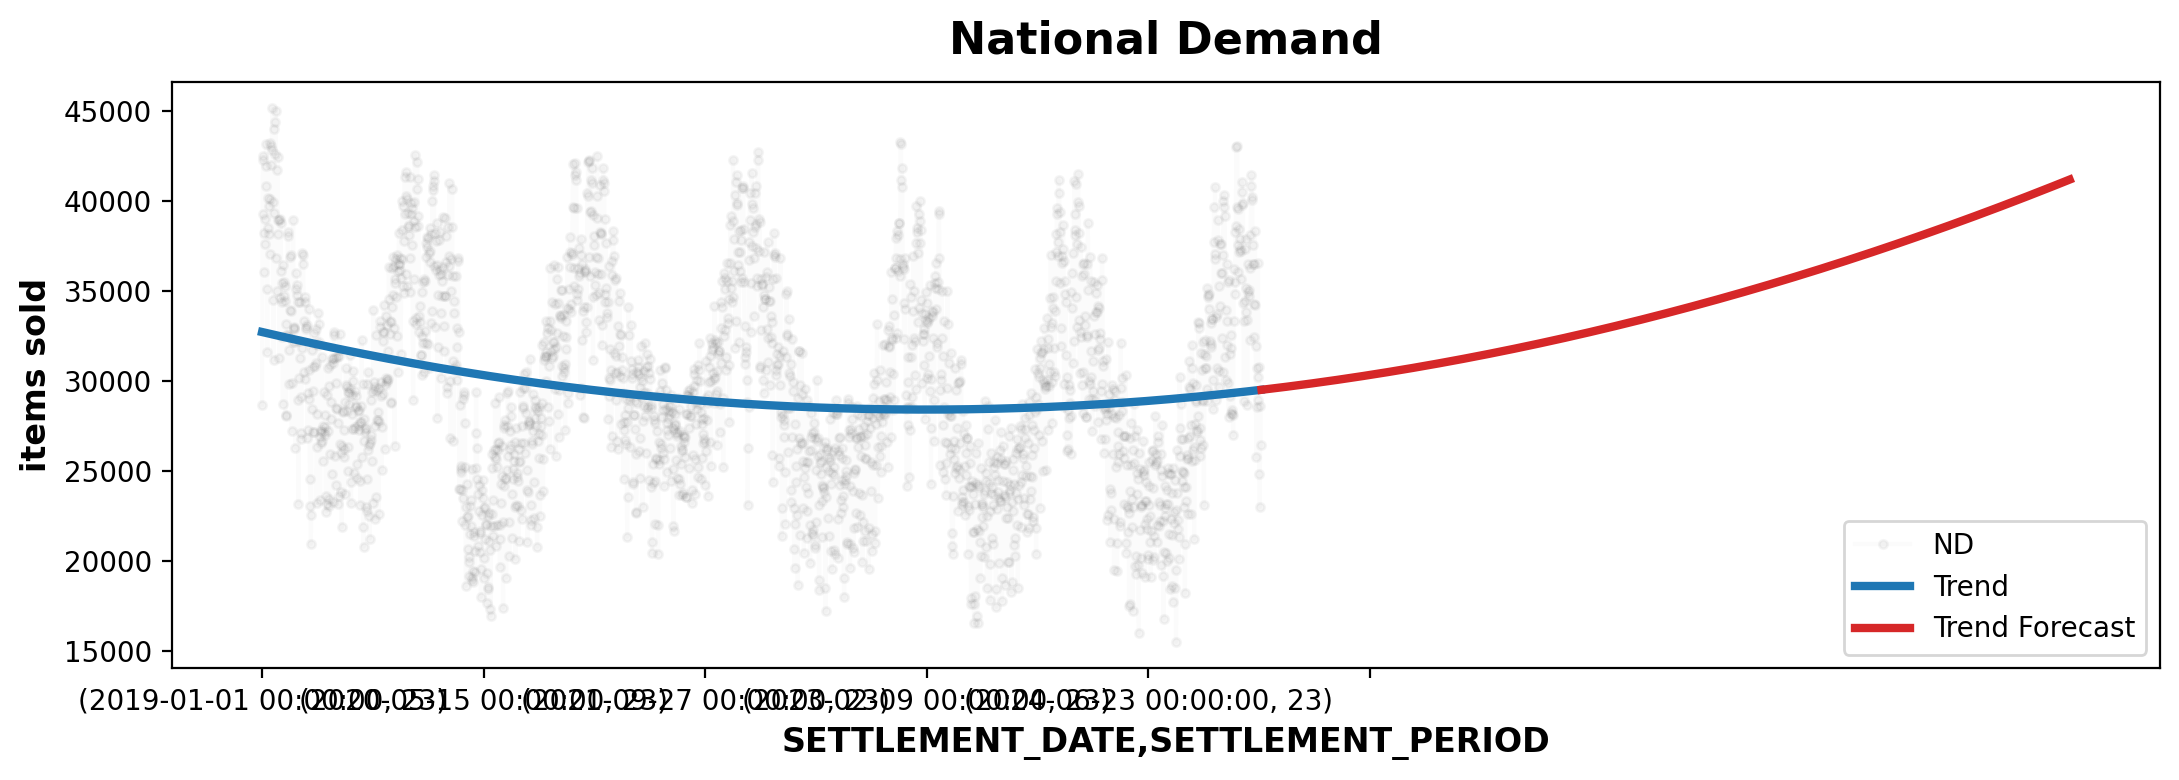

In [1093]:
ND_40 = df.loc[df.index.get_level_values('SETTLEMENT_PERIOD') == 23,]
y = ND_40.ND.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index= ND_40.index, order=2)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=365*5)

#Creating trend
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#Chart
ax = y.plot(**plot_params, alpha=0.05, title="National Demand", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();
# List all coefficient variables
coefficients = model.coef_
feature_names = X.columns

# Display coefficients with corresponding feature names
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')
print(f'Intercept:', model.intercept_)

## Adding calendar information

In [255]:
# Getting Bank Holidays
#https://www.api.gov.uk/gds/bank-holidays/#bank-holidays
#https://github.com/alphagov/calendars/blob/master/README.md
Calendar =pd.DataFrame()
API_URL = "https://www.gov.uk/bank-holidays.json"
response = requests.get(API_URL)

if response.status_code == 200:
   data = response.json()
else:
   print(f"Failed to fetch data: {response.status_code}, {response.text}")

#Get holidays for each key
for key, value in data.items():
    #print(f"{key}")
    Calendar = pd.concat([Calendar,pd.concat([pd.DataFrame(data[key]['events']),pd.DataFrame(data[key])], axis = 1)], axis = 0)
    
#Converting data type    
Calendar.date = pd.to_datetime(Calendar.date)
print(Calendar.info())
#Check for any duplicates
print('Duplicates: \n', Calendar.groupby('date').count().max())

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 0 to 92
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     252 non-null    object        
 1   date      252 non-null    datetime64[ns]
 2   notes     252 non-null    object        
 3   bunting   252 non-null    bool          
 4   division  252 non-null    object        
 5   events    252 non-null    object        
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 12.1+ KB
None
Duplicates: 
 title       3
notes       3
bunting     3
division    3
events      3
dtype: int64


In [243]:
Calendar.loc[Calendar.date == '2019-01-01',:]

title       date notes  bunting           division
0  New Year’s Day 2019-01-01           True  england-and-wales
0  New Year’s Day 2019-01-01           True           scotland
0  New Year’s Day 2019-01-01           True   northern-ireland

## UK Population slit
Source:
https://www.statista.com/statistics/716499/population-figures-by-country/#:~:text=The%20UK%20population%20was%2068.3%20million%20in%202023%2C,5.5%20million%2C%203.16%20million%2C%20and%201.92%20million%20respectively.

The UK population was 68.3 million in 2023, with 57.69 million people living in England, by far the most populous constituent country of the UK. In this year, Scotland, Wales, and Northern Ireland had populations of 5.5 million, 3.16 million, and 1.92 million respectively.

In [257]:
#Creating Dict for  population ratio
print('england-and-wales:' , round((57.69 + 3.16)/68.3, 2))
print('scotland:', round(5.5/68.3,2))
print('northern-ireland:', round(1.92/68.3,2))

UK_Population = { 'england-and-wales': round((57.69 + 3.16)/68.3, 2),'scotland': round(5.5/68.3,2),'northern-ireland': round(1.92/68.3,2)}
# adding column to Calendar with population ratio
Calendar['HolidayRatio'] = Calendar['division'].map(UK_Population)
#Removing not needed columns
Calendar = Calendar.drop(['division', 'events'],axis = 1)
# removing duplicates and leaving information hod may division holiday is in
Calendar = Calendar.groupby(['title','date','notes','bunting']).sum().reset_index()

england-and-wales: 0.89
scotland: 0.08
northern-ireland: 0.03


In [223]:
# removing duplicates and leaving information hod may division holiday is in
Calendar = Calendar.groupby(['title','date','notes','bunting']).sum().reset_index()

In [261]:
Calendar.loc[Calendar.date == '2019-01-01',:]

title       date notes  bunting  Ratio
65  New Year’s Day 2019-01-01           True    1.0

In [267]:
df = pd.merge(df, Calendar, how="left",left_on='SETTLEMENT_DATE', right_on='date')
df = df.drop(['date'], axis=1)

In [268]:
df.head(50)

EMBEDDED_SOLAR_GENERATION  NON_BM_STOR  EMBEDDED_SOLAR_CAPACITY  \
0                           0            0                  13052.0   
1                           0            0                  13052.0   
2                           0            0                  13052.0   
3                           0            0                  13052.0   
4                           0            0                  13052.0   
5                           0            0                  13052.0   
6                           0            0                  13052.0   
7                           0            0                  13052.0   
8                           0            0                  13052.0   
9                           0            0                  13052.0   
10                          0            0                  13052.0   
11                          0            0                  13052.0   
12                          0            0                  13052.0   
13                          0            0                  13052.0   
14                          0            0                  13052.0   
15                          0            0                  13052.0   
16                          6            0                  13052.0   
17                        107            0                  13052.0   
18                        367            0                  13052.0   
19                        698            0                  13052.0   
20                       1120            0                  13052.0   
21                       1540            0                  13052.0   
22                       1920            0                  13052.0   
23                       2100            0                  13052.0   
24                       2020            0                  13052.0   
25                       1880            0                  13052.0   
26                       1560            0                  13052.0   
27                       1220            0                  13052.0   
28                        902            0                  13052.0   
29                        553            0                  13052.0   
30                        236            0                  13052.0   
31                         48            0                  13052.0   
32                          0            0                  13052.0   
33                          2           54                  13052.0   
34                          0          142                  13052.0   
35                          1          142                  13052.0   
36                          0          142                  13052.0   
37                          0           98                  13052.0   
38                          0           36                  13052.0   
39                          0            0                  13052.0   
40                          0            0                  13052.0   
41                          0            0                  13052.0   
42                          0            0                  13052.0   
43                          0            0                  13052.0   
44                          0            0                  13052.0   
45                          0            0                  13052.0   
46                          0            0                  13052.0   
47                          0            0                  13052.0   
48                          0            0                  13052.0   
49                          0            0                  13052.0   

    IFA2_FLOW  IFA_FLOW  ELECLINK_FLOW  \
0           0      1553              0   
1           0      1554              0   
2           0      1505              0   
3           0      1503              0   
4           0      1503              0   
5           0      1505              0   
6           0      1406              0   
7           0      1410              0   
8   

In [30]:
#Adding trend feature -- we have trend feature later 
#array = df['SETTLEMENT_DATE'].unique()
#order = array.argsort()
#ranks = order.argsort()
#zip_iterator = zip(array, ranks)
#dictionary_Trend = dict(zip_iterator)
#df['time']= df['SETTLEMENT_DATE'].map(dictionary_Trend)

In [868]:
####autocorrelation within time
print(df.ND.autocorr(lag = 1*48))
print(df.ND.autocorr(lag = 2*48))
print(df.ND.autocorr(lag = 3*48))
print(df.ND.autocorr(lag = 4*48))
print(df.ND.autocorr(lag = 5*48))
print(df.ND.autocorr(lag = 6*48))
print('One week')
print(df.ND.autocorr(lag = 7*48))
print(df.ND.autocorr(lag = 28*48))
print('First Year')
print(df.ND.autocorr(lag = 365*48))
print(df.ND.autocorr(lag = 365*2*48))
print(df.ND.autocorr(lag = 365*3*48))
print(df.ND.autocorr(lag = 365*4*48))
print(df.ND.autocorr(lag = 365*5*48))

0.8858508342820653
0.8062822468257357
0.7770670370746767
0.7620251672259581
0.7668593735409385
0.8153018624753661
One week
0.8543647997072877
0.7315917290669628
First Year
0.7036939911348269
0.6380890682167683
0.5800887917673115
0.5276846645180414
0.42270992117012035


In [858]:
####autocorrelation within time
print(Daily.ND.autocorr(lag = 1))
print(Daily.ND.autocorr(lag = 2))
print(Daily.ND.autocorr(lag = 3))
print(Daily.ND.autocorr(lag = 4))
print(Daily.ND.autocorr(lag = 5))
print(Daily.ND.autocorr(lag = 6))
print(Daily.ND.autocorr(lag = 7))
print(Daily.ND.autocorr(lag = 28))
print(Daily.ND.autocorr(lag = 365))
print(Daily.ND.autocorr(lag = 365*2))
print(Daily.ND.autocorr(lag = 365*3))
print(Daily.ND.autocorr(lag = 365*4))

0.8912548078799333
0.764770819124906
0.7119377076139162
0.6979397491564631
0.7193075798904044
0.8056142248251661
0.8619931300133857
0.716848068930251
0.737973272428582
0.6515371881136643
0.6323914290935525
0.6438848015957545


In [ ]:
#Adding lag feature
df['WeekLag'] = df['Hardcover'].shift(1)
df['YearLag']


#### Seasonality

In [277]:
# setting up some functionfs
#annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sn.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sn.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

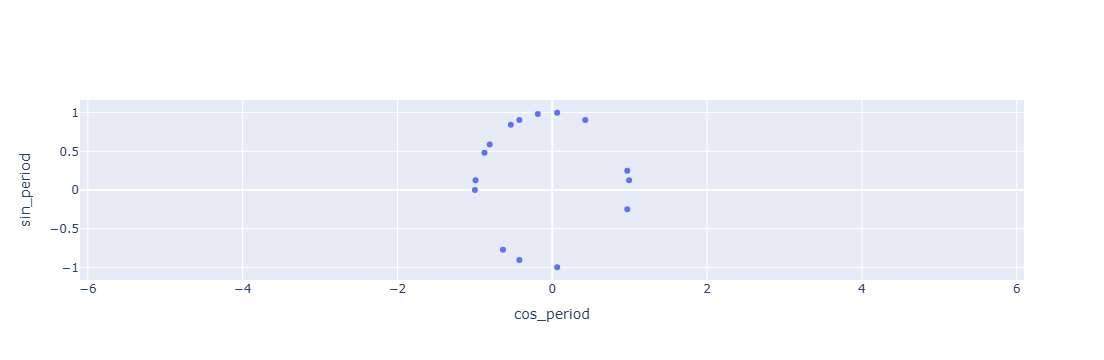

In [285]:
#Circular encoding, SETTLEMENT_PERIOD
df["period_norm"] = 2 * math.pi * df.index.get_level_values('SETTLEMENT_PERIOD') / df.index.get_level_values('SETTLEMENT_PERIOD').max()
df["cos_period"] = np.cos(df["period_norm"])
df["sin_period"] = np.sin(df["period_norm"])

#see on the chart
df_Circular = df[["cos_period","sin_period"]].sample(15).sort_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Circular.cos_period, y=df_Circular.sin_period, mode="markers"))
fig.update_layout(xaxis = dict(title="cos_period"),
                 yaxis = dict(title="sin_period", scaleanchor = "x", scaleratio = 1))
fig.show()


## Aggregetaed National Demand (ND) data to a daily level

In [345]:
##Aggregating data to Daily level
Daily = df.groupby('SETTLEMENT_DATE').sum()
Daily['year_month'] =  Daily.index.get_level_values('SETTLEMENT_DATE').astype(str).str.slice(stop = 7)
Daily['month_day'] =  Daily.index.get_level_values('SETTLEMENT_DATE').astype(str).str.slice(start= 5,stop = 10)
#### adding new columns with YMD
Daily['year'] =  Daily.index.get_level_values('SETTLEMENT_DATE').astype(str).str.slice(stop = 4)
#### adding new columns with YMD
Daily['month'] =  Daily.index.get_level_values('SETTLEMENT_DATE').astype(str).str.slice(start= 5,stop = 7)
#### converting month to int (encoding)
Daily['month'] = Daily['month'].astype(int)
Daily['year'] = Daily['year'].astype(int)
#resetting some variables
Daily['iso_week'] = Daily.index.get_level_values('SETTLEMENT_DATE').isocalendar().week
Daily['iso_day'] = Daily.index.get_level_values('SETTLEMENT_DATE').isocalendar().day
Daily['iso_week_day'] = Daily['iso_week'].astype(str) + '-' + Daily['iso_day'].astype(str)
#removing not needed columns
Daily = Daily.drop(['period_norm','cos_period',	'sin_period'],axis= 1)

<Axes: title={'center': 'National Demand'}, xlabel='SETTLEMENT_DATE', ylabel='ND'>

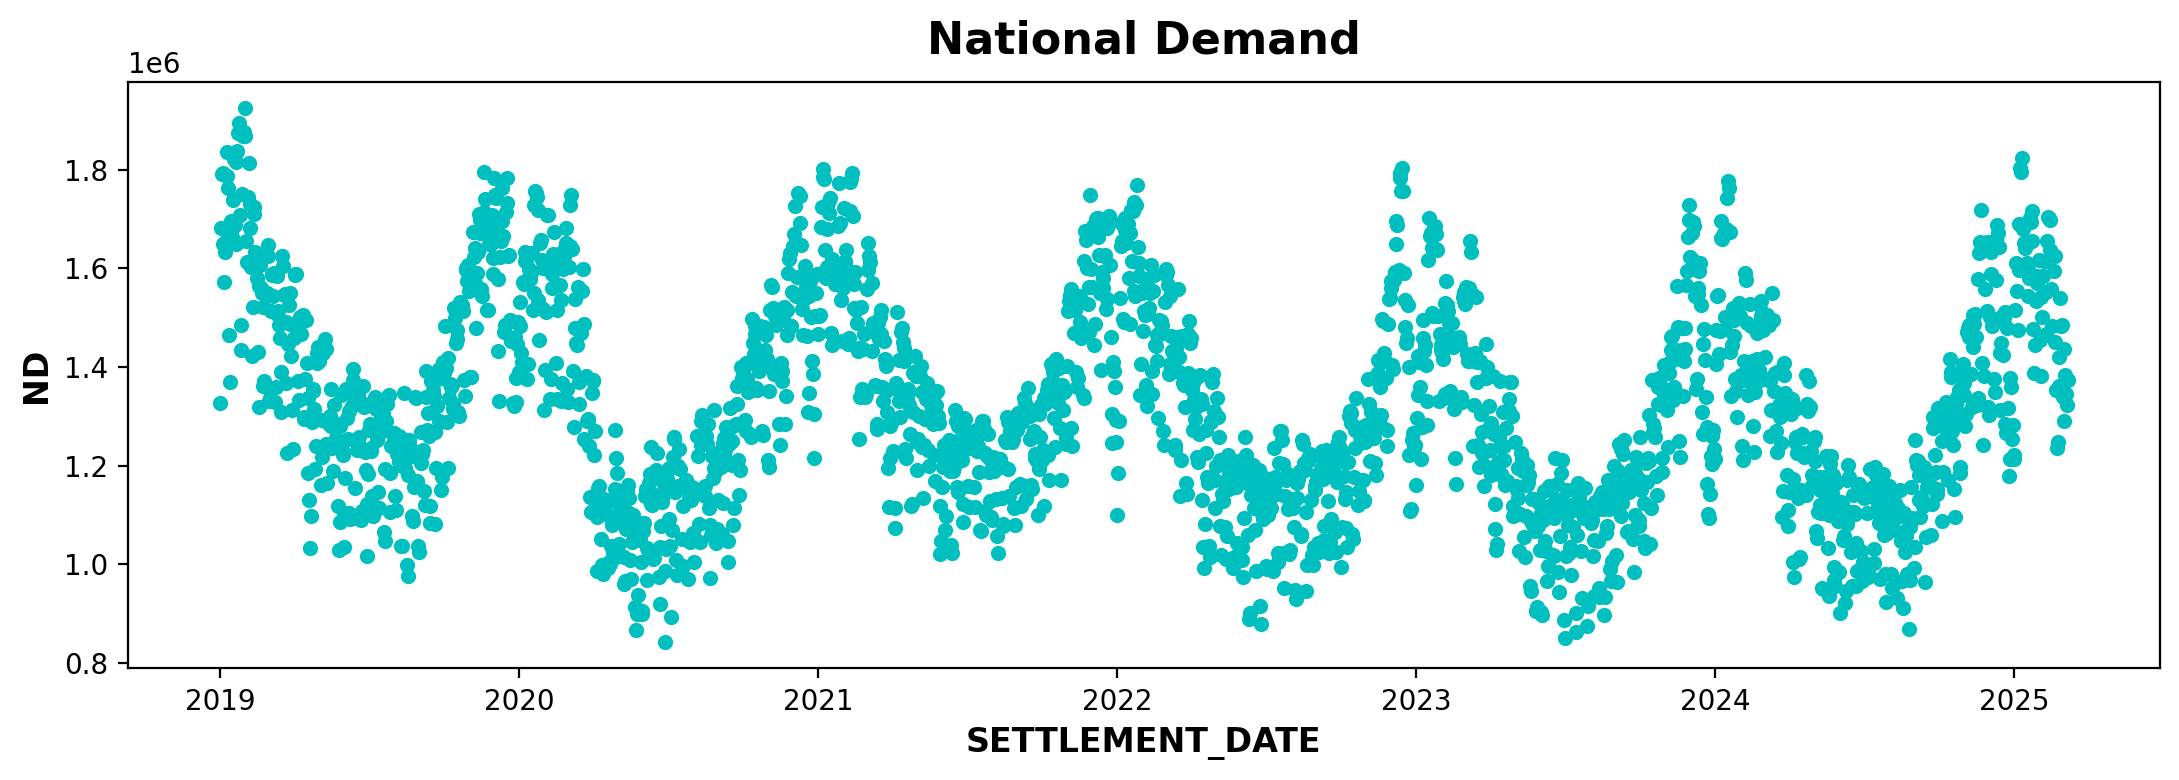

In [289]:
Daily.reset_index().plot.scatter(x= 'SETTLEMENT_DATE' ,y= 'ND' ,color ='c',title='National Demand')

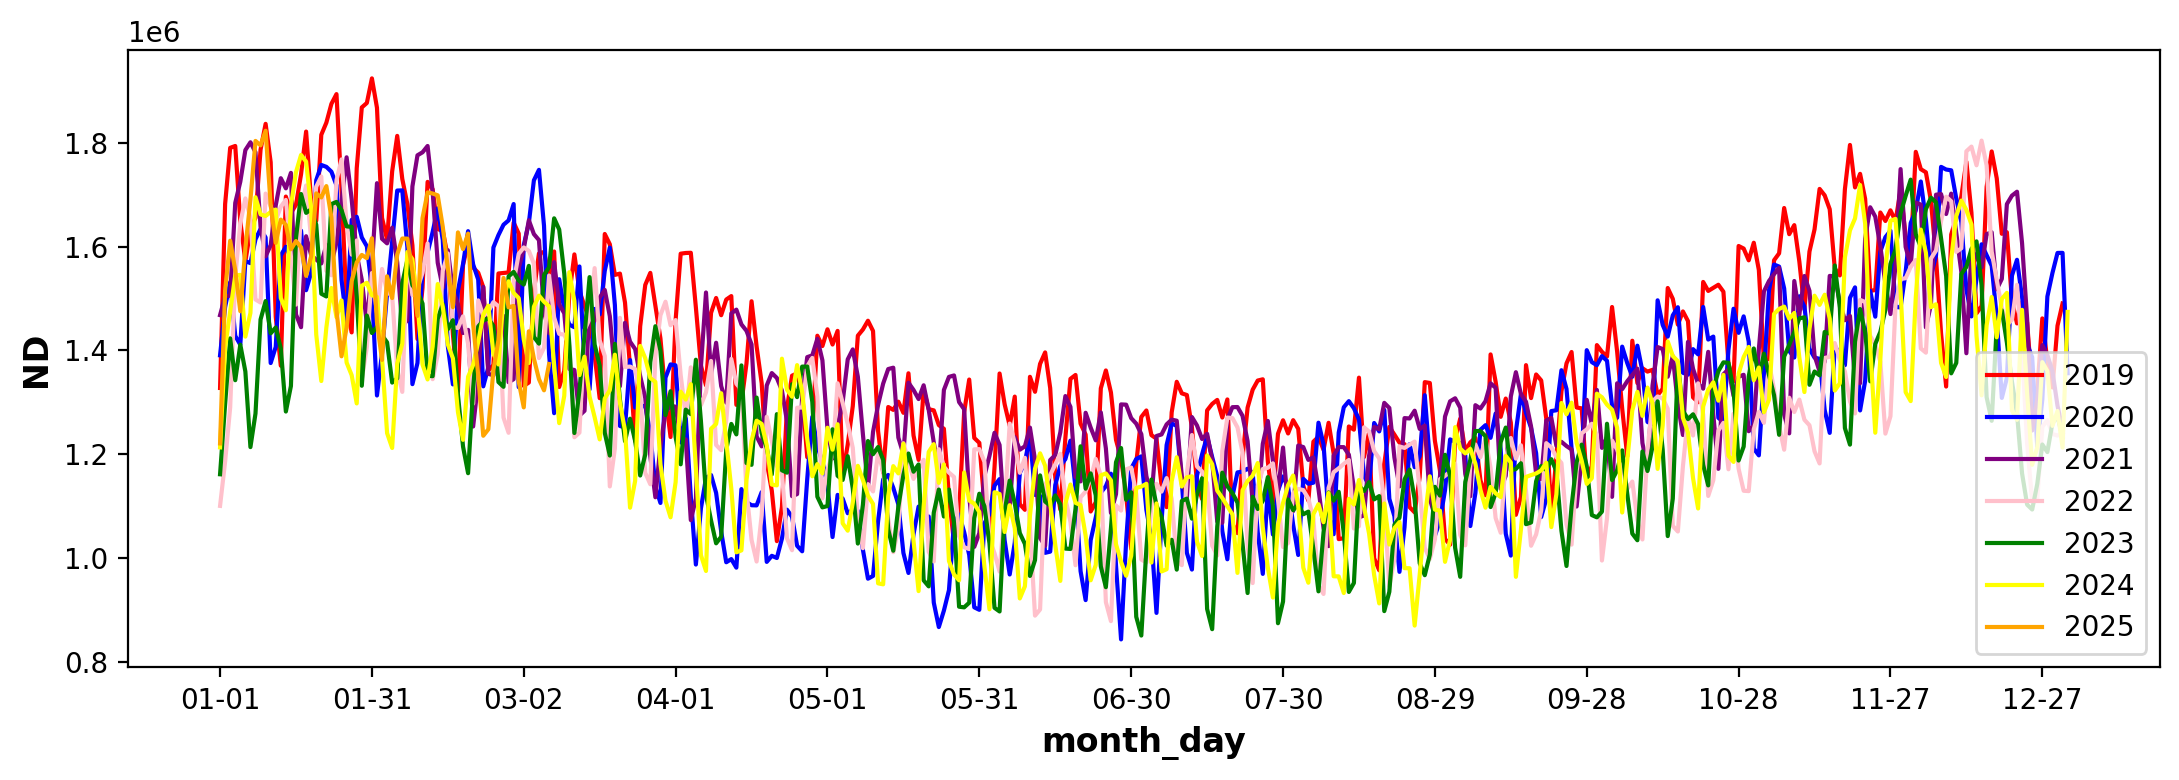

In [375]:
sn.lineplot(x='month_day', y='ND', hue='year', 
             data=Daily,
             palette=['red', 'blue', 'purple', 'pink','green','yellow','orange'])
plt.legend(loc= 'lower right', bbox_to_anchor=(1, 0))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

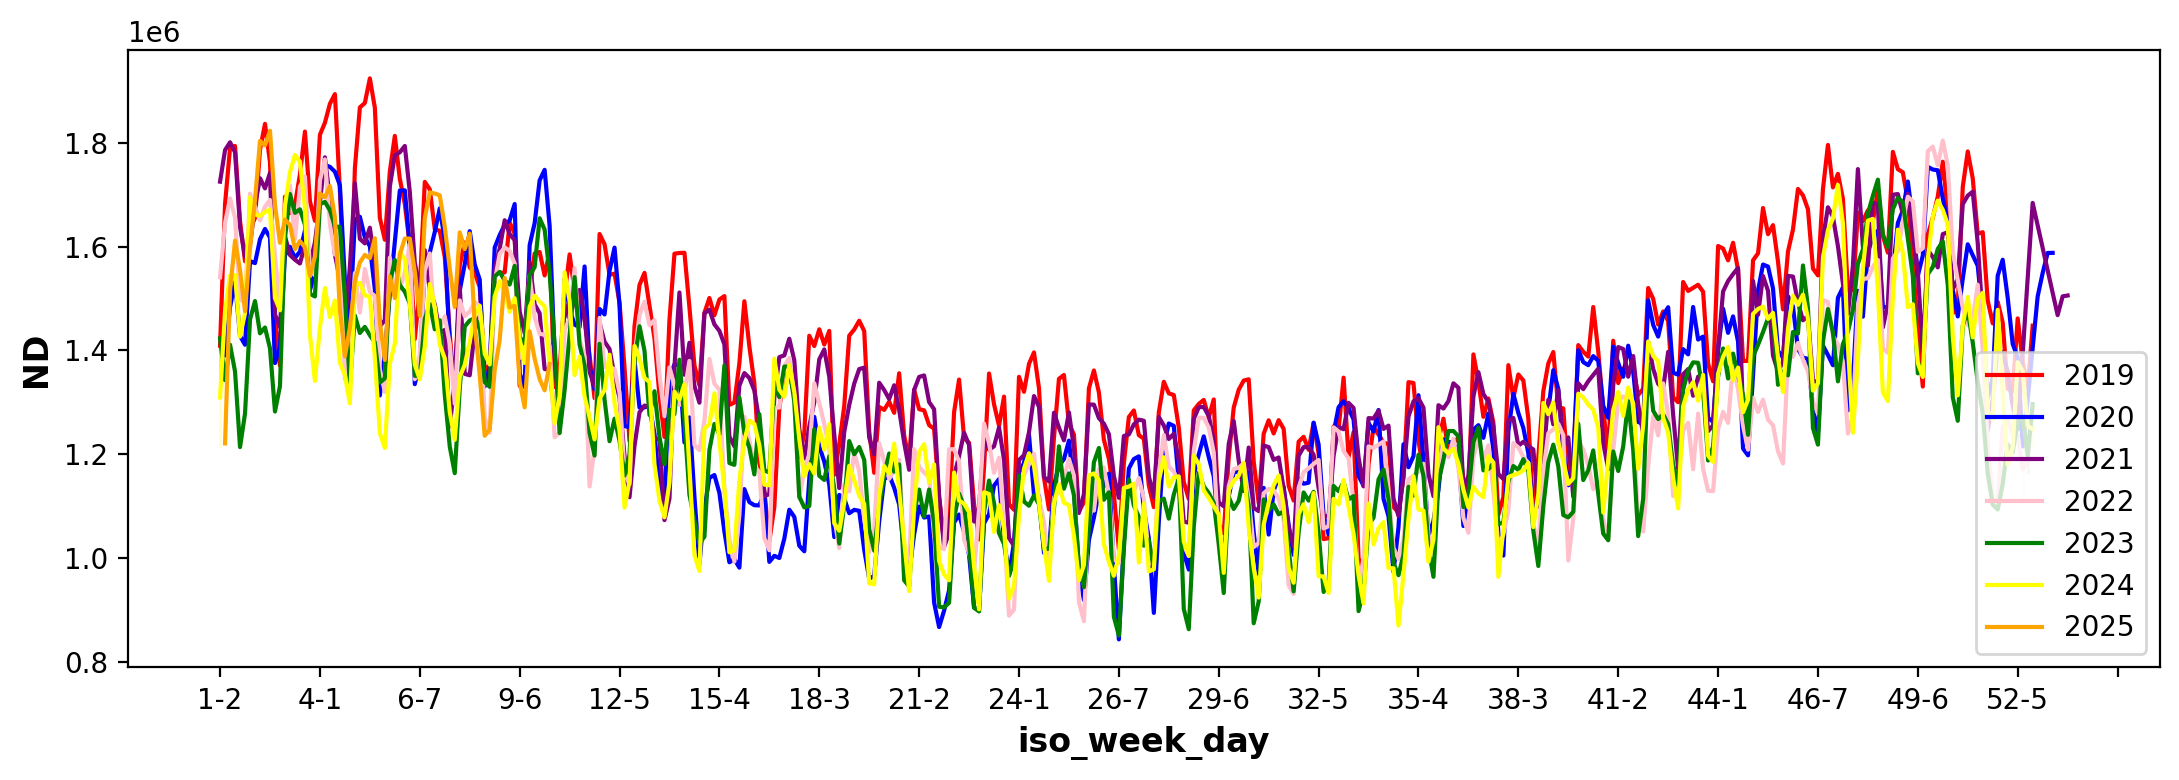

In [377]:
sn.lineplot(x= 'iso_week_day', y='ND', hue='year', 
             data=Daily,
             palette=['red', 'blue', 'purple', 'pink','green','yellow','orange'])
plt.legend(loc= 'lower right', bbox_to_anchor=(1, 0))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(25))

KeyboardInterrupt: 

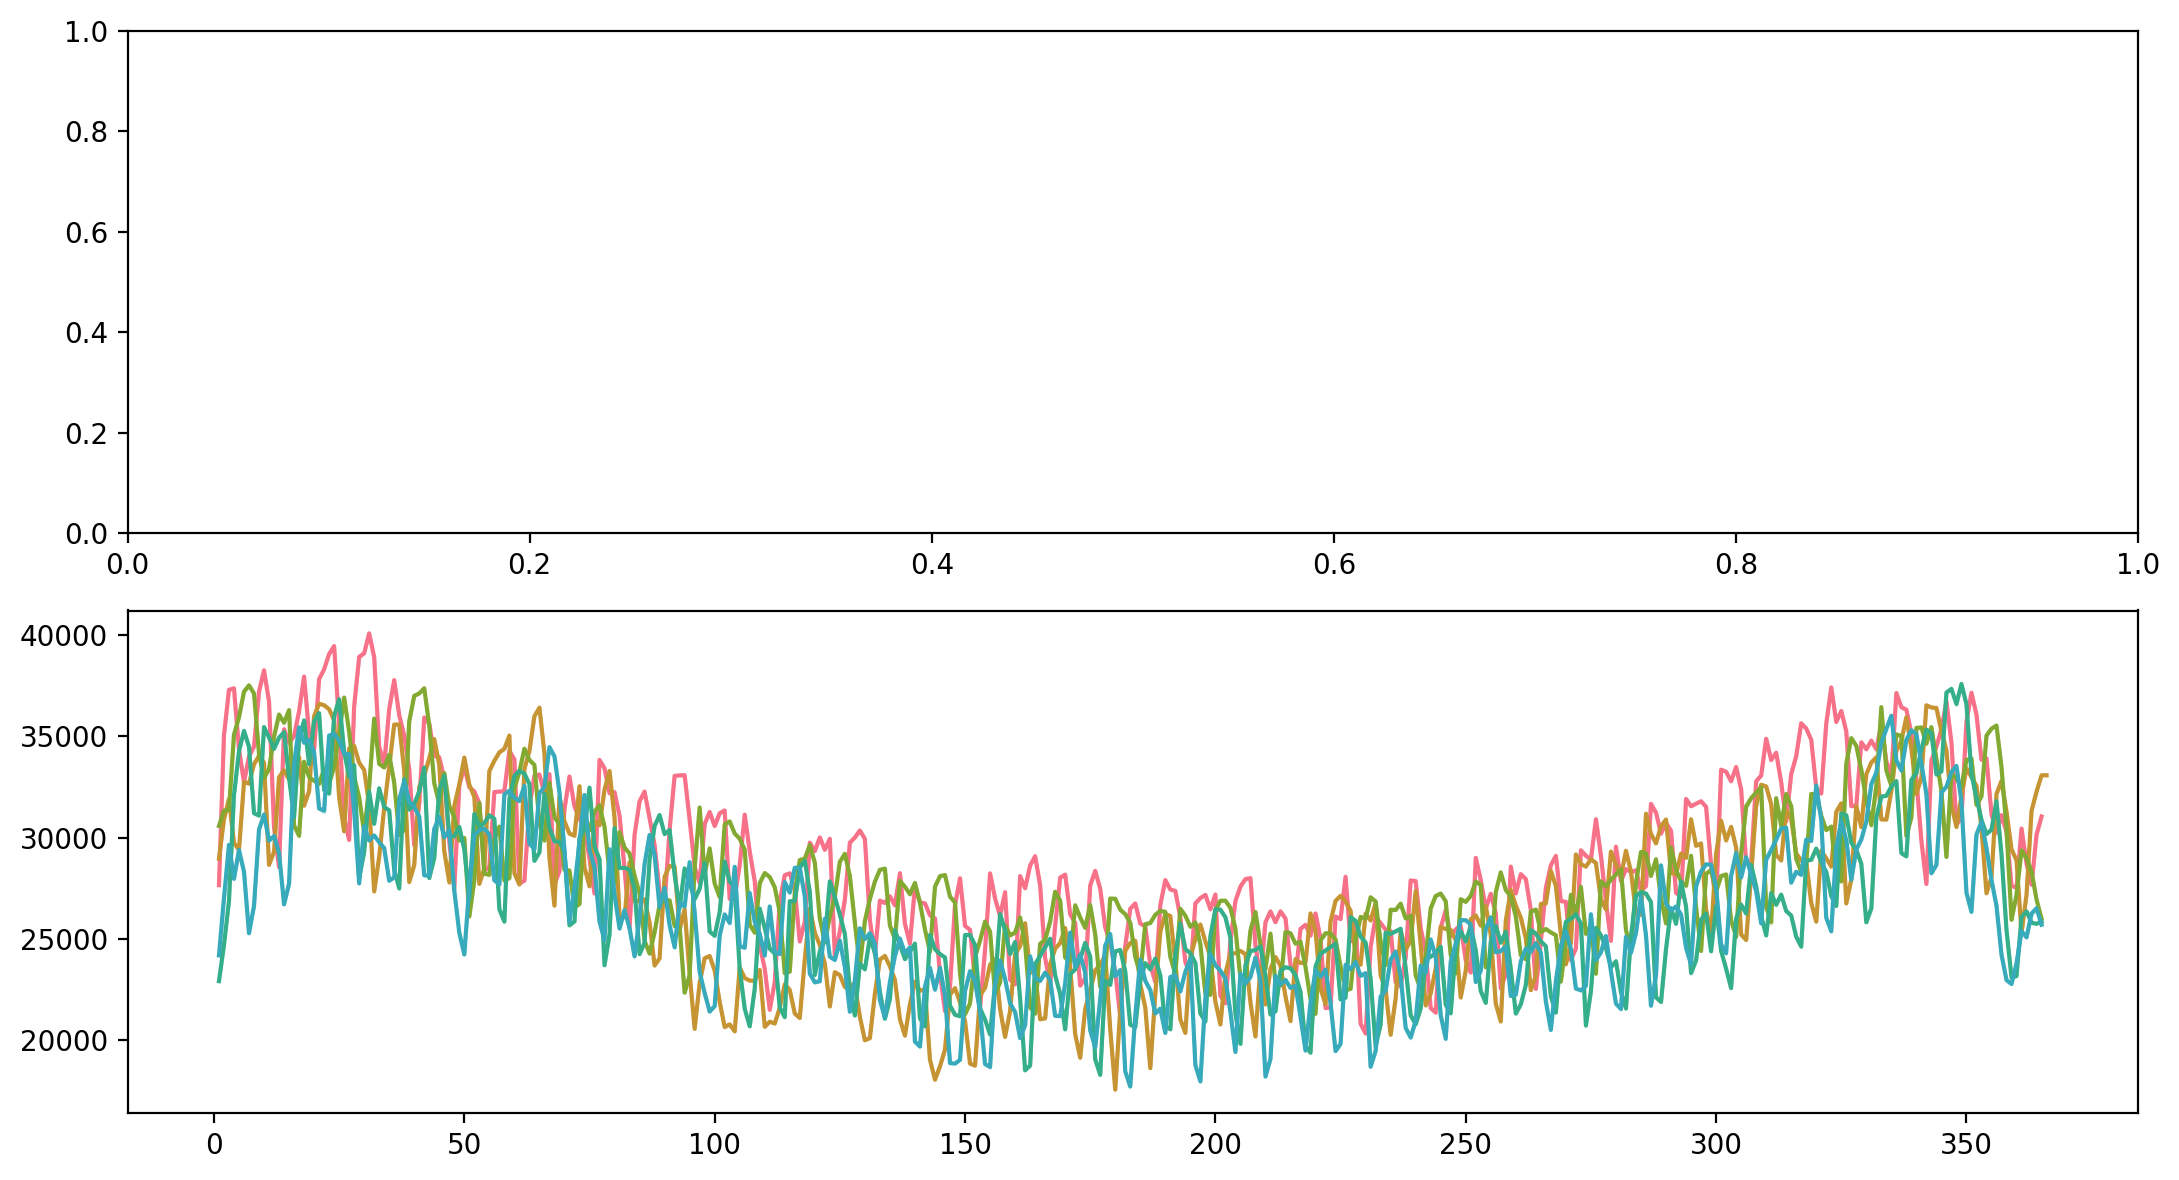

In [99]:
X = Daily.copy()

# days within a week
X["day"] = X.iso_day  # the x-axis (freq)
X["week"] = X.iso_week  # the seasonal period (period)

# days within a year
#X["dayofyear"] = X.dayofyear
#X["year"] = X.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
#seasonal_plot(X, y="ND", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="ND", period="year", freq="dayofyear", ax=ax1);

<Axes: title={'center': 'National Demand'}, xlabel='SETTLEMENT_DATE', ylabel='ND'>

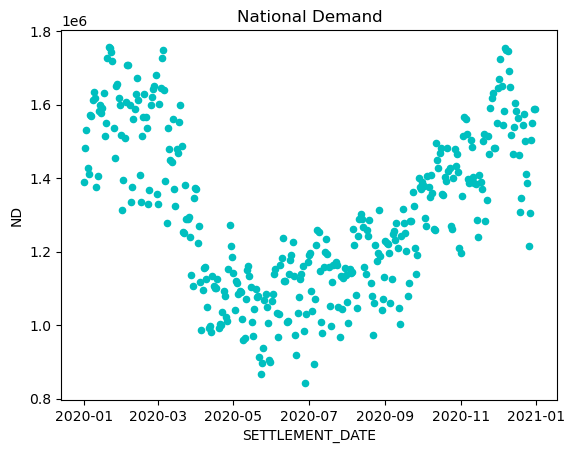

In [298]:
Daily.loc[Daily.year == 2020, :].reset_index().plot.scatter(x= 'SETTLEMENT_DATE' ,y= 'ND' ,color ='c',title='National Demand')

<Axes: xlabel='year_month', ylabel='ND'>

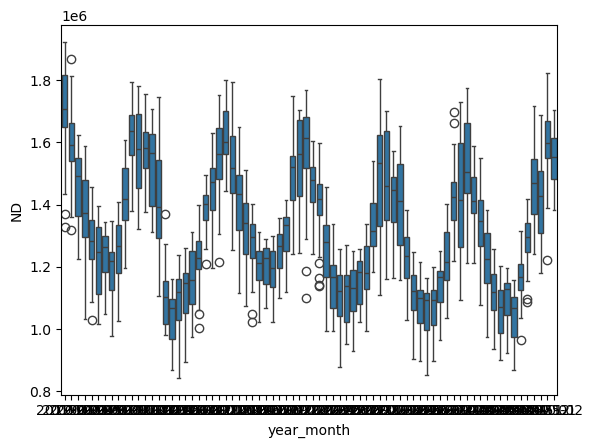

In [299]:
#Box Plot chart for Each Year
sn.boxplot(x='year_month', y='ND', data=Daily.loc[:,['year_month','ND']])

## Skewness 
Values between -1 and -0.5 (left) or between 0.5 and 1 (right) indicate moderate skewness, while values less than -1 or greater than 1 suggest high skewness. 

<Axes: title={'center': 'National Demand KDE plot'}, ylabel='Density'>

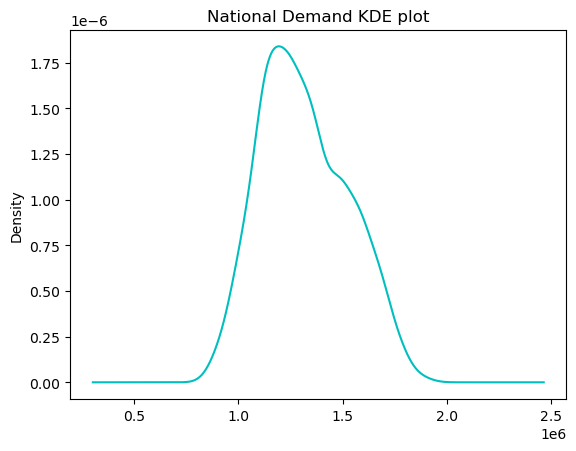

In [548]:
Daily.ND.plot(kind = 'kde', title ='National Demand KDE plot',color = 'c') ##KDE Kneral Desity Estimation

In [552]:
print(Daily.ND.skew())
print(np.log(Daily.ND).skew())
print(np.sqrt(Daily.ND).skew())
print(skew(stats.boxcox(Daily.ND)[0]))

0.3045183053111718
-0.006396978122317447
0.15127306477606928
-0.0006303636951681057


Conclusion: There is moderate right skewness. The best result gives us BoxCox transormation or Log transformation

In [300]:
MonthlyStatistics = Daily.groupby(['year','month']).describe()

In [301]:
MonthlyStatistics.ND

count          mean            std        min         25%  \
year month                                                              
2019 1       31.0  1.701050e+06  155547.110903  1327420.0  1649246.00   
     2       28.0  1.589620e+06  131657.955839  1319660.0  1541512.75   
     3       31.0  1.465819e+06  116814.907772  1225028.0  1363666.50   
     4       30.0  1.369430e+06  144674.232371  1032242.0  1295973.00   
     5       31.0  1.283146e+06  109709.667387  1029025.0  1226379.50   
...           ...           ...            ...        ...         ...   
2024 10      31.0  1.283071e+06   85716.429189  1087434.0  1246193.00   
     11      30.0  1.467910e+06  127748.547366  1241139.0  1370714.75   
     12      31.0  1.429318e+06  148088.136588  1179371.0  1307683.50   
2025 1       31.0  1.598536e+06  122149.629602  1220564.0  1548989.50   
     2       11.0  1.552002e+06   95688.588810  1381497.0  1483558.50   

                  50%         75%        max  
year month                                    
2019 1      1707615.0  1818500.00  1924096.0  
     2      1591105.5  1661852.00  1867471.0  
     3      1491979.0  1548572.00  1625006.0  
     4      1372832.0  1480164.25  1587977.0  
     5      1284308.0  1349726.50  1457018.0  
...               ...         ...        ...  
2024 10     1295273.0  1340379.50  1417142.0  
     11     1471149.0  1546277.50  1718628.0  
     12     1427836.0  1506730.00  1688557.0  
2025 1      1598664.0  1668078.00  1823182.0  
     2      1552064.0  1615363.50  1704358.0  

[74 rows x 8 columns]

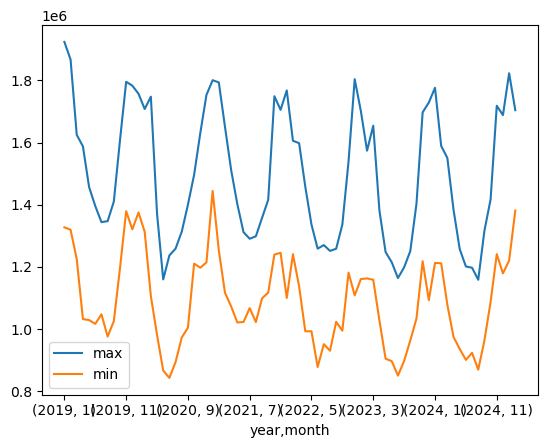

In [302]:
MonthlyStatistics.ND.loc[:,['max','min']].plot();

## Monthly aggregation

In [304]:
##Aggregating data to Monthly level
Monthly = df.loc[df.index.get_level_values('SETTLEMENT_DATE') <'2025-02-01',:].groupby('year_month').sum()
#### adding new columns with YMD
Monthly['year'] =  Monthly.index.get_level_values('year_month').astype(str).str.slice(stop = 4)
#### adding new columns with YMD
Monthly['month'] =  Monthly.index.get_level_values('year_month').astype(str).str.slice(start= 5,stop = 7)
#### converting month to int (encoding)
Monthly['month'] = Monthly['month'].astype(int)
Monthly['year'] = Monthly['year'].astype(int)

<Axes: xlabel='year', ylabel='ND'>

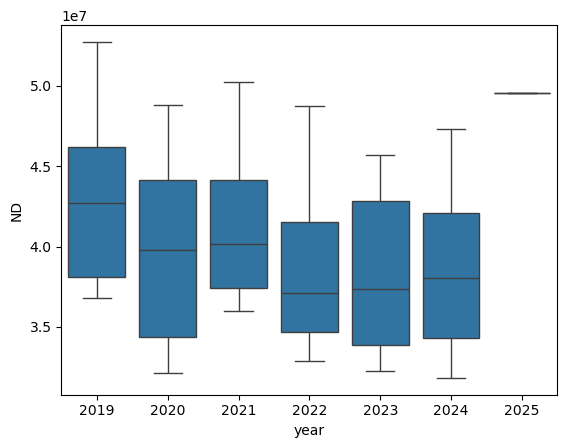

In [305]:
#Box Plot chart for Each Year
sn.boxplot(x='year', y='ND', data=Monthly.loc[:,['year','ND']])

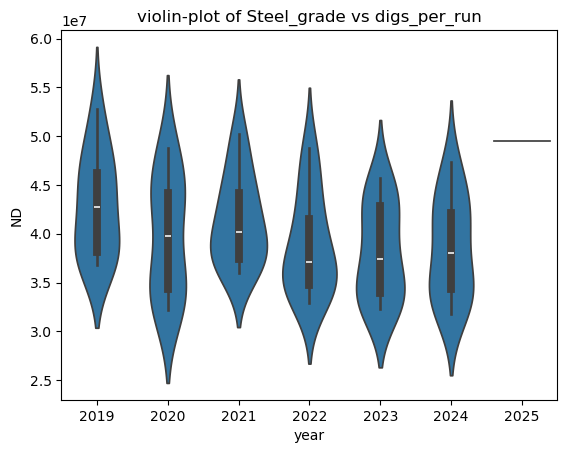

In [306]:
sn.violinplot(x='year',y='ND',data=Monthly )
plt.title("violin-plot of Steel_grade vs digs_per_run")
plt.show()

<Axes: xlabel='month', ylabel='ND'>

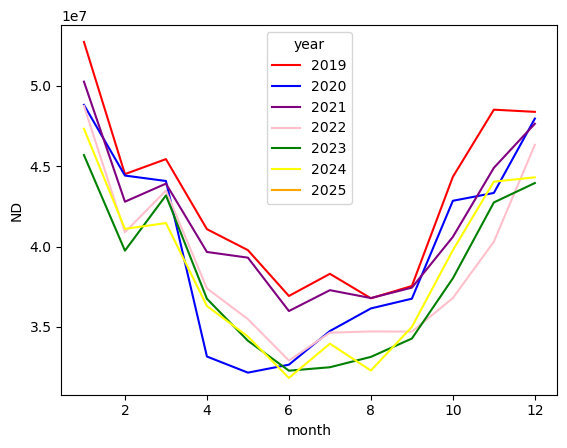

In [307]:
sn.lineplot(x='month', y='ND', hue='year', 
             data=Monthly,
             palette=['red', 'blue', 'purple', 'pink','green','yellow','orange'])

### Shape changes

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 107232 entries, (Timestamp('2019-01-01 00:00:00'), 1) to (Timestamp('2025-02-11 00:00:00'), 48)
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   EMBEDDED_SOLAR_GENERATION  107232 non-null  int64  
 1   NON_BM_STOR                107232 non-null  int64  
 2   EMBEDDED_SOLAR_CAPACITY    107232 non-null  float64
 3   IFA2_FLOW                  107232 non-null  int64  
 4   IFA_FLOW                   107232 non-null  int64  
 5   ELECLINK_FLOW              107232 non-null  int64  
 6   _full_text                 107232 non-null  object 
 7   TSD                        107232 non-null  int64  
 8   BRITNED_FLOW               107232 non-null  int64  
 9   ND                         107232 non-null  int64  
 10  MOYLE_FLOW                 107232 non-null  int64  
 11  ENGLAND_WALES_DEMAND       107232 non-null  int64  
 12  NSL_FLOW          

<Axes: xlabel='SETTLEMENT_PERIOD', ylabel='ND'>

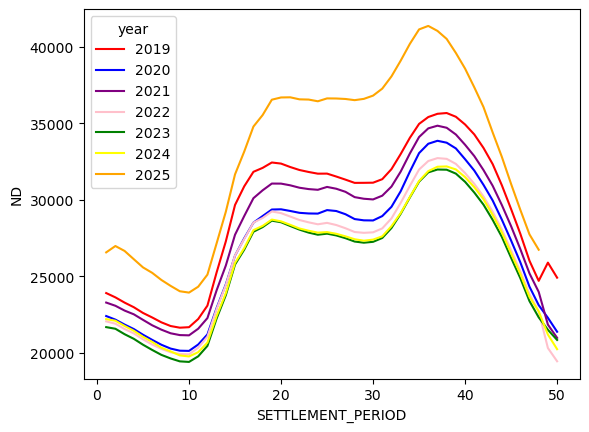

In [380]:
df.groupby(['year',df.index.get_level_values('SETTLEMENT_PERIOD')]).mean('ND')

sn.lineplot(x='SETTLEMENT_PERIOD', y='ND', hue='year', 
             data= df.groupby(['year',df.index.get_level_values('SETTLEMENT_PERIOD')]).mean('ND'),
             palette=['red', 'blue', 'purple', 'pink','green','yellow','orange'])

In [402]:
#adding Daily Total for ND
df = df.join(Daily.rename(columns={'ND': 'Daily'}).Daily)
#Create DAily shape - it should sum to 1 for each day
df['Shape'] = df.ND / df.Daily

In [412]:
#Data check
df.groupby(df.index.get_level_values('SETTLEMENT_DATE')).sum().Shape

SETTLEMENT_DATE
2019-01-01    1.0
2019-01-02    1.0
2019-01-03    1.0
2019-01-04    1.0
2019-01-05    1.0
             ... 
2025-02-07    1.0
2025-02-08    1.0
2025-02-09    1.0
2025-02-10    1.0
2025-02-11    1.0
Name: Shape, Length: 2234, dtype: float64

C:\Users\akwid\AppData\Local\Temp\ipykernel_34008\3967390140.py:6: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sn.lineplot(ax=axes[int(np.floor((i-1)/3)),(i-1) % 3], x='SETTLEMENT_PERIOD', y='Shape', hue='year',
C:\Users\akwid\AppData\Local\Temp\ipykernel_34008\3967390140.py:6: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sn.lineplot(ax=axes[int(np.floor((i-1)/3)),(i-1) % 3], x='SETTLEMENT_PERIOD', y='Shape', hue='year',
C:\Users\akwid\AppData\Local\Temp\ipykernel_34008\3967390140.py:6: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sn.lineplot(ax=axes[int(np.floor((i-1)/3)),(i-1) % 3], x='SETTLEMENT_PERIOD', y='Shape', hue='year',
C:\Users\akwid\AppData\Local\Temp\ipykernel_34008\3967390140.py:6: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sn.lineplot(ax=axes[int(np.floor((i-1)/3)),(i

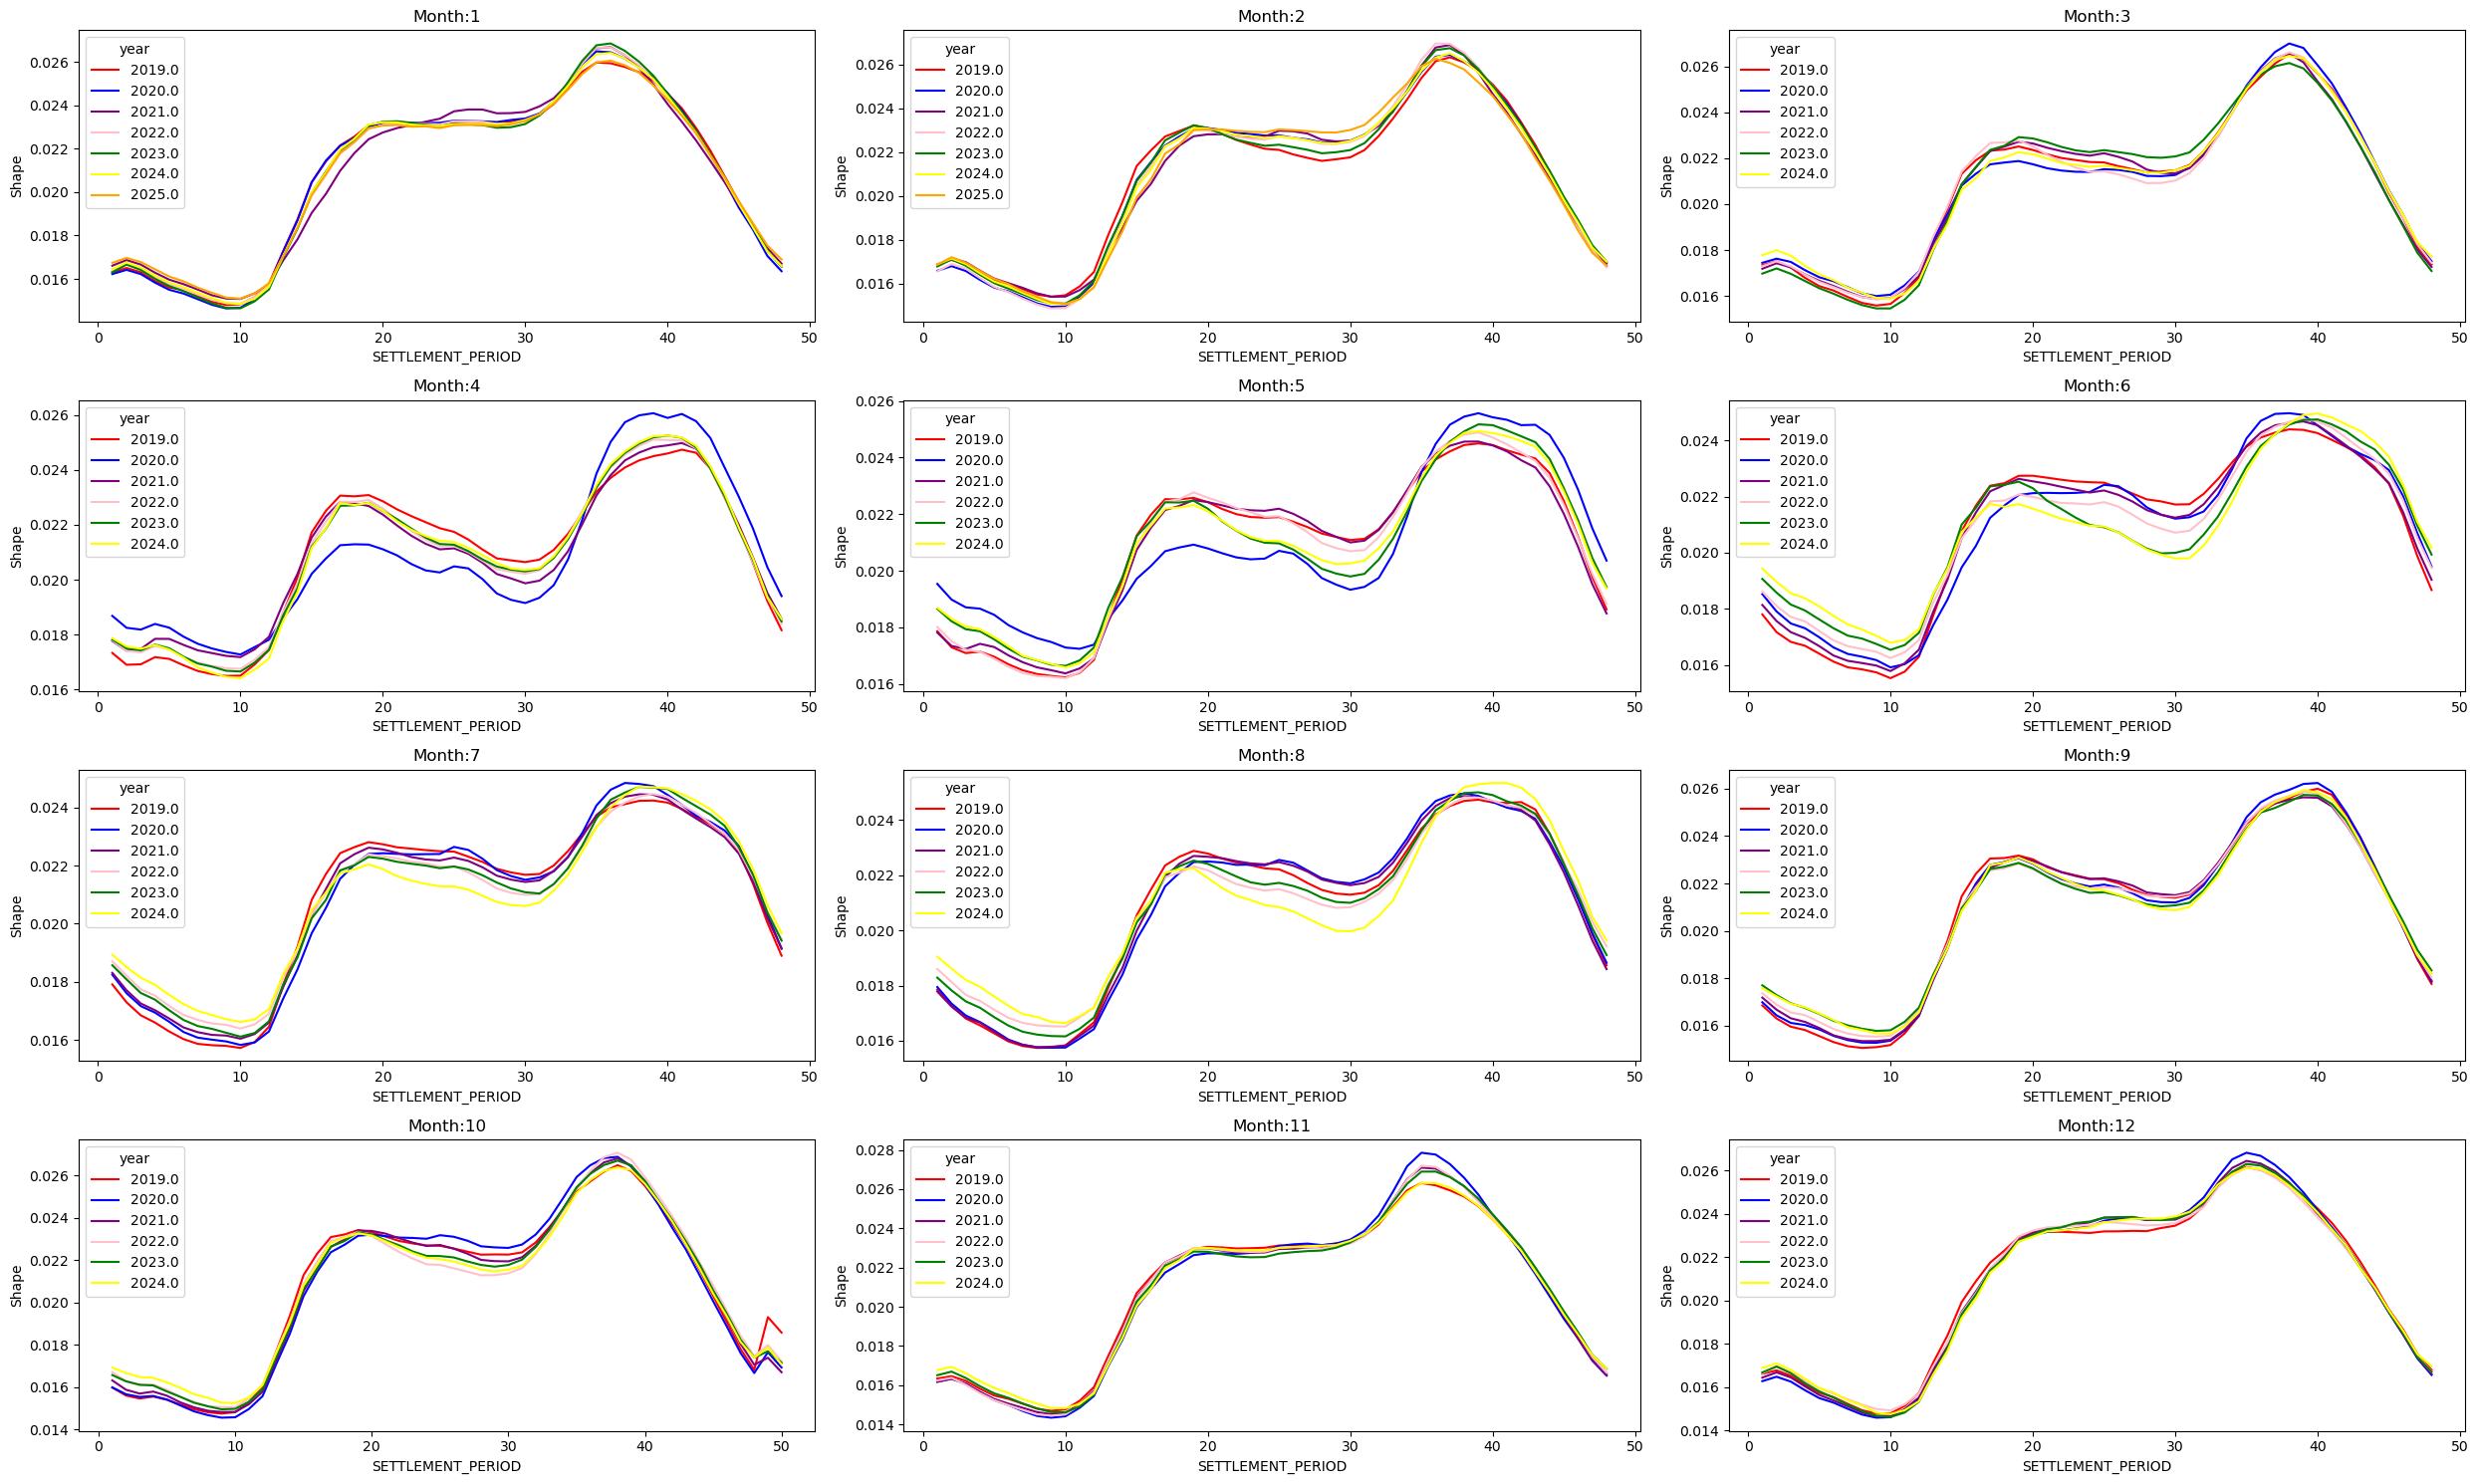

In [546]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(4, 3, figsize=(25, 15))
for i in df.month.unique():
    #plt.figure(figsize=(9,5))
    plt.title(i)
    sn.lineplot(ax=axes[int(np.floor((i-1)/3)),(i-1) % 3], x='SETTLEMENT_PERIOD', y='Shape', hue='year', 
                 data= df.loc[df.month == i,:].groupby(['year_month',df.loc[df.month == i,:].index.get_level_values('SETTLEMENT_PERIOD')]).mean('Shape'),
                 palette=['red', 'blue', 'purple', 'pink','green','yellow','orange'])
    axes[int(np.floor((i-1)/3)),(i-1) % 3].set_title(f"Month:{i}")
    # Adjust layout
plt.tight_layout()
    
    # Show the plot
plt.show()

Conclusion:
* 2020 in many months has completly diferent shape due to Covid locdowns, especially in  April and May
* For some months we can see lower usage during the day period, for the years 2023/ 2024, in months : Maqy, June, July, August. This may suggest higher roll out of solar panels and embeded generation.

In [ ]:
*Check autocorrelation
* check for trend
* check for seasoanlity
* Lag values - is it visible at all ? last year usagage ?
* check if I should split the problem total + shape or just do everything together or create different forecast model per Period
* GAM
* ARIMA

### GDP data

In [310]:
#Data Source: https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/gdpmonthlyestimateuktimeseriesdataset

MGDP = pd.read_csv("mgdp.csv")

### Covid data

### Weather Data

Python Libraries for Historical Weather Data
Meteostat (pip install meteostat)
Climate Data Store API (for ECMWF ERA5 data)

In [964]:
#pip install meteostat

In [996]:
# Get nearby weather stations
from meteostat import Stations
stations = Stations()
stations = stations.nearby(51.508, -0.1257)
station = stations.fetch(1)

# Print DataFrame
print(station)

                        name country region    wmo  icao  latitude  longitude  \
id                                                                              
03779  London Weather Centre      GB    ENG  03779  EGRB   51.5167    -0.1167   

       elevation       timezone hourly_start hourly_end daily_start  \
id                                                                    
03779        5.0  Europe/London   1992-04-01 2010-02-01  1992-04-03   

       daily_end monthly_start monthly_end     distance  
id                                                       
03779 2010-01-31    2006-01-01  2009-01-01  1150.544985  


In [1000]:
from datetime import datetime
from meteostat import Hourly

# Set time period
start = datetime(2019, 1, 1)
end = datetime(2025, 12, 31, 23, 59)

# Get hourly data
data = Hourly('03779', start, end)
data = data.fetch()

# Print DataFrame
print(data)

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2019-01-01 00:00:00   6.9   4.4  84.0   NaN   NaN  258.0   9.3  18.5  1035.1   
2019-01-01 01:00:00   6.6   4.1  84.0   NaN   NaN  262.0   9.3  20.4  1034.9   
2019-01-01 02:00:00   6.2   4.0  86.0   NaN   NaN  261.0   9.3  18.5  1034.9   
2019-01-01 03:00:00   5.9   3.7  86.0   NaN   NaN  263.0   9.3  18.5  1034.8   
2019-01-01 04:00:00   5.8   3.8  87.0   NaN   NaN  264.0   9.3  18.5  1034.8   
...                   ...   ...   ...   ...   ...    ...   ...   ...     ...   
2025-03-23 12:00:00  11.3   6.0  70.0   NaN   NaN  194.0  20.4  33.3  1013.0   
2025-03-23 13:00:00  12.9   5.6  61.0   NaN   NaN  194.0  20.4  33.3  1013.2   
2025-03-23 14:00:00  11.9   5.5  65.0   NaN   NaN  179.0  20.4  33.3  1012.9   
2025-03-23 15:00:00  12.0   5.2  63.0   NaN   NaN  185.0  20.4  33.3  1013.1   
2025-03-23 16:00:00  11.5   5.1  65.0   

In [986]:
#pip install openmeteo-requests

Note: you may need to restart the kernel to use updated packages.


In [987]:
#pip install requests-cache retry-requests numpy pandas


   ---------------------------------------- 0.0/61.4 kB ? eta -:--:--
   --------------------------------- ------ 51.2/61.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 61.4/61.4 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/66.4 kB ? eta -:--:--
   ---------------------------------------- 66.4/66.4 kB 3.7 MB/s eta 0:00:00


In [1004]:
#https://open-meteo.com/en/docs/historical-weather-api?hourly=relative_humidity_2m,apparent_temperature,precipitation,pressure_msl,cloud_cover,wind_speed_10m&start_date=2019-01-01&end_date=2025-03-17&latitude=51.508&longitude=-0.1257
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.508,
	"longitude": -0.1257,
	"start_date": "2015-01-01",
	"end_date": "2025-03-17",
	"hourly": ["relative_humidity_2m", "apparent_temperature", "precipitation", "pressure_msl", "cloud_cover", "wind_speed_10m","temperature_2m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

							# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(6).ValuesAsNumpy()
hourly_data = {"date": pd.date_range(start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),freq = pd.Timedelta(seconds = hourly.Interval()),inclusive = "left")}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 51.49384689331055°N -0.16302490234375°E
Elevation 15.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s
                           date  temperature_2m  relative_humidity_2m  \
0     2015-01-01 00:00:00+00:00          4.7520             92.581322   
1     2015-01-01 01:00:00+00:00          5.0020             92.595726   
2     2015-01-01 02:00:00+00:00          5.3520             92.940712   
3     2015-01-01 03:00:00+00:00          5.7020             92.959892   
4     2015-01-01 04:00:00+00:00          6.0020             93.300568   
...                         ...             ...                   ...   
89491 2025-03-17 19:00:00+00:00          6.0585             77.160858   
89492 2025-03-17 20:00:00+00:00          5.8085             79.629364   
89493 2025-03-17 21:00:00+00:00          5.7085             82.488846   
89494 2025-03-17 22:00:00+00:00          5.3585             83.918488   
89495 2025-03-17 23:00:00+00:00          4.6585             85.948624   
